# Character Impact Project (Part 7) - Improving our Facial Recognition
## Deep Learning Facial Recognition
### Alden Chico

---

## Premise

In the last section of our blog series, we covered OpenCV's Local Binary Pattern Histogram (LBPH) Facial Recognition capabilities. LBPH was able to net us an F-score of $0.77{\pm}0.3$ on our testing dataset of 4 individuals. While this is okay, there are 18 individual named characters in the first season of <i>The Office</i> that we have to take into consideration. How does our classifier hold up when we extend its classification to this many characters? The answer is, not too well.

In this section of our blog series, we will extend our naive LBPH facial classifier to all the named characters in <i>The Office</i>. We will then go over image preprocessing steps to try to improve the LBPH classifier's performance. After taking image preprocessing steps into consideration, we will then look at deep learning and how Google's FaceNet classifier performs on our dataset. <i><b>Spoilers: FaceNet doesn't make a single mistake on our dataset</b></i>.

With the stunning results we get from FaceNet, we then improve our facial detection approach with deep learning using Multi-Task Convolutional Neural Networks (MTCNN), and finally, piece all of our work together to a robust and accurate facial detection and classification model. Let's begin.

<figure>
<img src="https://www.indiewire.com/wp-content/uploads/2017/05/office_us-e1513645533437.jpg?w=502" alt="Time to get down to business" class="center" style=width:449px;height:300px;>
<figcaption><center><b>We're going full AI up in here...</b></center></figcaption>
</figure> 

---

## Recap

Let's recap our work from last time. The first step of our process is going to be importing the libraries we used from the last blog post. 

The last two libraries are special. The first library, ```import_ipynb```, is a library that allows us to reference an ipynb file and import all the functions for use in this python notebook. You can install ```import_ipynb``` by running ```pip install import-ipynb``` into the project's environment. By importing ```import_ipynb```, we can import a file called ```Facial_Recognition_Module``` that's a python notebook containing all the functions that we created for facial detection / classification from last time. We will be modifying the functions in this file throughout the course of this section to adapt image preprocessing steps and new facial detection/classification models, but as of now, we'll just import all the functions as is.

In [1]:
# Ignore FutureWarning warnings that may pop up from importing following libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Libraries from last part of the project
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from collections import defaultdict

# Importing functions from the last part of the project's ipynb file as a library for this part
import import_ipynb
from Facial_Recognition_Module import *

importing Jupyter notebook from Facial_Recognition_Module.ipynb


---

Now that all the libraries are imported to our project, let's run our ```cross_validate``` function on an image dataset that contains all 18 credited characters from the first season of <i>The Office</i>.

In [3]:
character_dict, original_list, label_list = prepare_data('reference/7-Hyperparameter_Tuning/*/*.png', -2)

In [4]:
naive_lbph = cv2.face.LBPHFaceRecognizer_create()
pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1 = cross_validate(original_list, label_list, 
                                                                                         naive_lbph, character_dict,
                                                                                         folds=3, random_state=42)

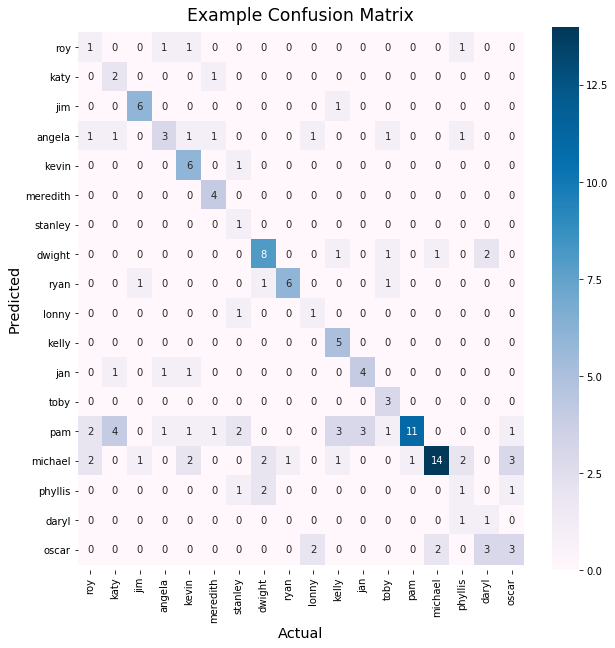

In [5]:
example = confusion_matrix_list[0]

_ = plt.figure(figsize=(10,10))
_ = plt.tight_layout()
_ = sns.heatmap(example, annot=True, cmap='PuBu')
_ = plt.title('Example Confusion Matrix', fontsize='xx-large')
_ = plt.xlabel('Actual', fontsize='x-large')
_ = plt.ylabel('Predicted', fontsize='x-large')
_ = plt.ylim(example.shape[1] + 0.2, -0.2)

In [6]:
print("Average F1 Score from 3-Fold CV: {:.4f}".format(cv_average_f1))

Average F1 Score from 3-Fold CV: 0.5031


---

As you can see, after 3-Fold cross-validation, the classifier only reached an F1-score of 0.5031. Expanding our dataset to 18 people led to a classification drop of 27 points from our 4 person dataset. We can attribute this newfound error to the curse of dimensionality. More classes for a supervised classification task leads to an inherent drop in accuracy. We'll first work on image preprocessing to improve this drop in performance. 

In [7]:
''' Display all images from a given list '''

def show_all_images(img_list, columns=4):
    
    # Shape matplotlib subplot
    size = len(img_list)
    rows = int(size / columns)
    if size % columns  != 0 or rows == 0:
        rows += 1
    
    figsize = (10, 5)
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    
    # Convert grayscale images to BGR
    if img_list[0].shape[-1] != 3:
        for idx, img in enumerate(img_list):
            img_list[idx] = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Draw all the images if more than one row can be drawn with given column number
    i = 0
    if rows > 1:
        for row in range(rows):
            for column in range(columns):
                if i >= len(img_list):
                    axs[row][column].axis('off')
                    i += 1
                    continue
                img = img_list[i]
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                _ = axs[row][column].imshow(img)
                _ = axs[row][column].axis('off')
                i += 1
    
    # Draw all images if images only take up one row
    else:
        for column in range(columns):
            if i >= len(img_list):
                    _ = axs[column].axis('off')
                    i += 1
                    continue
            img = img_list[i]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            _ = axs[column].imshow(img)
            _ = axs[column].axis('off')
            i += 1 
        
        
    _ = plt.axis('off')
    plt.show()

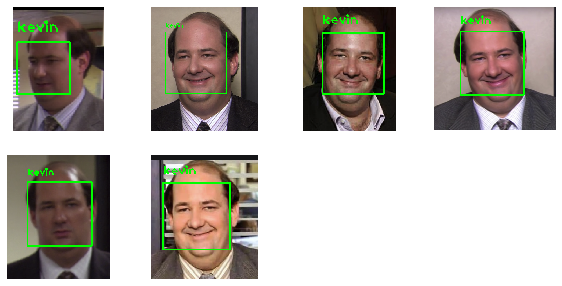

In [8]:
# Show all images correctly labeled as Kevin
pred_character = 'kevin'
actual_character = 'kevin'

example = pred_img_df_list[0]
img_list = example.loc[pred_character, actual_character]

_ = show_all_images(img_list)

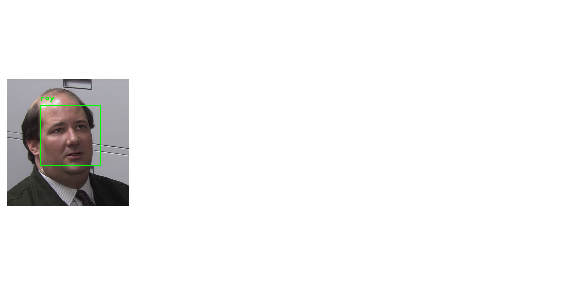

In [9]:
# Show all images that should have been labeled Kevin, but were labelled Roy instead
pred_character = 'roy'
actual_character = 'kevin'

example = pred_img_df_list[0]
img_list = example.loc[pred_character, actual_character]

_ = show_all_images(img_list)

The function we just wrote ```show_all_images``` takes in an image list and displays all the images within the list using ```matplotlib```. It will be useful to have this function in order to check how the classifier performs through each step if we need to. I mostly used this function in testing to verify that the facial classifier was working as intended.

---

## Rescaling Images to Image Size Median for Uniformity

Rescaling images so they're all the same size is important because it removes much of the variance that can occur when images are not the same size. We create the ```normalize_face_image_size``` function to rescale all the images to the median face image size in the provided dataset. The ```cv2.resize``` function we use, by default, resizes images using bilinear interpolation, which means it fills empty pixels with the linear value in between pixels that are already defined. This is good enough for resizing our images. We can compare images side-by-side by defining a ```compare_two_images``` function to do just that.

In order to work our image preprocessing steps into the entire face dataset automatically, I also created a ```preprocess_images``` function to take in a list of image preprocessing functions and apply it to the provided dataset in the order listed. 

In [10]:
''' Resize the face images to the median face image size from the list'''

def normalize_face_image_size(gray_face_list):
    
    # Gather all the width/height dimensions from the face images
    x_size_list = y_size_list = []
    for face in gray_face_list:
        x_size_list.append(face.shape[0])
        y_size_list.append(face.shape[1])
    
    # Find the median from the width/height dimensions
    x_median = int(np.median(x_size_list))
    y_median = int(np.median(y_size_list))
    dim = (x_median, y_median)
    
    # Resize the face image to the median face image size
    rescale_face_list = []
    for face in gray_face_list:
        if face.shape[0] == 0 or face.shape[1] == 0:
            gray_face_list.remove(face)
            continue
        rescale_face = cv2.resize(face, dim)
        rescale_face_list.append(rescale_face)
        
    return rescale_face_list

In [11]:
''' Draw side by side image comparisons using matplotlib '''

def compare_two_images(img_1, img_2):
    
    # Create subplots plot for a 1x2 image subplot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the first image
    _ = axs[0].imshow(img_1, cmap='gray')
    _ = axs[0].axis('off')
    
    # Display the second image
    _ = axs[1].imshow(img_2, cmap='gray')
    _ = plt.axis('off')
    plt.show()

In [12]:
''' Apply preprocessing steps to provided face image list '''

def preprocess_images(gray_face_list, preprocess_steps):
    
    # Make a copy of the face image list
    process_face_list = gray_face_list.copy()
    
    # If there are no preprocessing steps provided, return the original list
    if len(preprocess_steps) == 0:
        return process_face_list
    
    # Apply the preprocessing steps provided in the list to the list
    for step in preprocess_steps: 
        process_face_list = step(process_face_list)
    return process_face_list

---

Now that we have a means to preprocess the face images before classification, another function that I made is ```prepare_image_dictionaries```. This function takes in a list of original image data, a list of labels associated with the images, and a list of preprocessing steps as arguments. It first detects faces in the image data and stores them in img_dict and face_dict ```defaultdict``` objects, respectively. Then, the function runs the preprocessing steps on the face images in the ```defaultdict``` and replaces the list stored within with the preprocessed image list. The function returns img_dict and face_dict.

In [13]:
''' Detect faces from original images and apply preprocessing steps
    Organize the images into defaultdicts where value entries are lists containing original and face images
'''

def prepare_image_dictionaries(original_list, label_list, preprocess_steps):
    
    img_dict = defaultdict(list)
    face_dict = defaultdict(list)
    gray_face_list = []
    
    # Organize the original image and face lists in the img_dict/face_dict by their corresponding labels
    for img, label in zip(original_list, label_list):
        faces, _ = detect_faces(img)
        if faces is not None:
            img_dict[label].append(img)
            face_dict[label].append(faces[0])
    
    # Add all the faces from the face dictionary to a gray_face_list super list
    for _, face_list in face_dict.items():
        for face in face_list:
            gray_face_list.append(face)
    
    # Process all the faces in the super list
    process_face_list = preprocess_images(gray_face_list, preprocess_steps)
    
    # Store the processed faces to the face dictionary
    start = end = 0
    for label, img_list in img_dict.items():
        start, end = end, end + len(img_list)
        face_dict[label] = process_face_list[start:end]
  
    return img_dict, face_dict

In [14]:
preprocess_steps = [normalize_face_image_size]
character_dict, original_list, label_list = prepare_data('reference/7-Hyperparameter_Tuning/*/*.png', -2)
data_dict, face_dict = prepare_image_dictionaries(original_list, label_list, preprocess_steps)

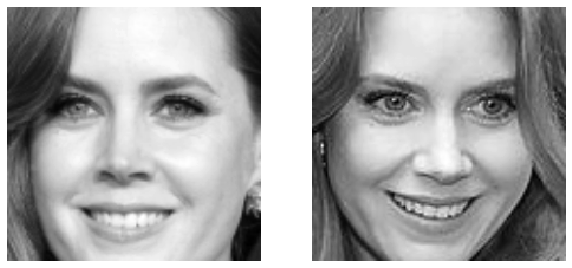

Example 1 Image Size: (215, 215) pixels
Example 2 Image Size: (215, 215) pixels


In [15]:
example_1 = face_dict[1][0]
example_2 = face_dict[1][1]

_ = compare_two_images(example_1, example_2)
print('Example 1 Image Size: {} pixels'.format(example_1.shape))
print('Example 2 Image Size: {} pixels'.format(example_2.shape))

With the image preprocessing functions set up and the ```normalize_face_image_size``` function defined, we now edit our custom ```cross_validate``` function to accept image preprocessing steps as an argument. The function now preprocesses all the face images prior to training the LBPH facial classifier. The outcome of preprocessing our face images by uniform face size is shown below.

In [16]:
''' Edit the cross_validate function to accept preprocessing steps for image editing'''

def cross_validate(original_list, label_list, face_recognizer, character_dict, 
                   preprocess_steps, folds=5, random_state=None):
    
    pred_face_list = []
    f1_average_list = []
    confusion_matrix_list = []
    pred_img_df_list = []
    
    # Shuffle the grayscale image face list and original images
    cv_img_list, cv_label_list = shuffle_original(original_list, label_list, random_state)
    
    # Prepare image dictionaries with preprocessing steps applied to grayscale face images
    data_dict, face_dict = prepare_image_dictionaries(cv_img_list, cv_label_list, preprocess_steps)
        
    for i in range(folds):
            
        # Add images from each label into the training and testing set of the defaultdict
        test_img_list = train_face_list =[]
        test_label_list = train_label_list = np.array([])
        
        for (label, img_list), (_, face_list) in zip(data_dict.items(), face_dict.items()):
            list_len = len(img_list)
            test_sample_len = int(1/folds * list_len)
            
            test_split = img_list[i*test_sample_len : (i+1)*test_sample_len]
            test_img_list = test_img_list + test_split
            test_label_list = np.append(test_label_list, np.full(len(test_split), label))
            
            train_split = face_list[:i*test_sample_len] + face_list[(i+1)*test_sample_len:]
            train_face_list = train_face_list + train_split
            train_label_list = np.append(train_label_list, np.full(len(train_split), label))
    
        # Train the LBPH face recognizer on the preprocessed face images
        train_label_list = train_label_list.astype(int)
        face_recognizer.train(train_face_list, train_label_list)
        
        
        # Generate the confusion matrix by predicting test images
        confusion_matrix, pred_img_df = generate_confusion_matrix(character_dict, test_img_list, test_label_list, 
                                                                  face_recognizer)
        confusion_matrix_list.append(confusion_matrix)
        pred_img_df_list.append(pred_img_df)
        
        # Gather f1 score information from data gathered in testing phase
        f1_score_list = generate_f1_scores(confusion_matrix, character_dict)
        character_average_f1 = np.mean(f1_score_list)
        f1_average_list.append(character_average_f1)
        
    # Average the f1 scores together
    cv_average_f1 = np.mean(f1_average_list)
    
    return pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1

In [17]:
character_dict, original_list, label_list = prepare_data('reference/7-Hyperparameter_Tuning/*/*.png', -2)
naive_lbph = cv2.face.LBPHFaceRecognizer_create()
preprocess_steps = [normalize_face_image_size]
pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1 = cross_validate(original_list, label_list, 
                                                                                         naive_lbph, character_dict,
                                                                                         preprocess_steps,
                                                                                         folds=3, random_state=42)

In [18]:
print("Average F1 Score from 3-Fold CV: {:.4f}".format(cv_average_f1))

Average F1 Score from 3-Fold CV: 0.5684


The outcome of 3-Fold cross-validation on our dataset is an improvement of 6 points over naive classification. We now know that image preprocessing shows improvements over feeding the classifier with unedited image data, but sometimes, image preprocessing doesn't show measured improvements as intended.

## Gaussian Blur

The idea behind adding Gaussian blur prior to training a classifier is that Gaussian blur removes much of the noise that unedited image data tends to show. Noise for a classifier would be features like wrinkles or smiling face creases. The classifier, in theory, should be able to read points of greater variance when small innocuous details in the image don't help the classifier read the "bigger picture" differences of the image.

Below, we use ```cv2.GaussianBlur``` to apply a Gaussian blur to all the face image data. The results of applying blur and normalizing the face image sizes is shown below.

In [19]:
'''Apply a Gaussian blur filter to the face list'''

def apply_blur(gray_face_list):
    blur_face_list = []
    for face in gray_face_list:
        if face.shape[0] == 0 or face.shape[1] == 0:
            gray_face_list.remove(face)
            continue
        blur = cv2.GaussianBlur(face, (7, 7), 0)
        blur_face_list.append(blur)
    return blur_face_list

In [20]:
preprocess_steps = [apply_blur, normalize_face_image_size]
data_dict, face_dict = prepare_image_dictionaries(original_list, label_list, preprocess_steps)

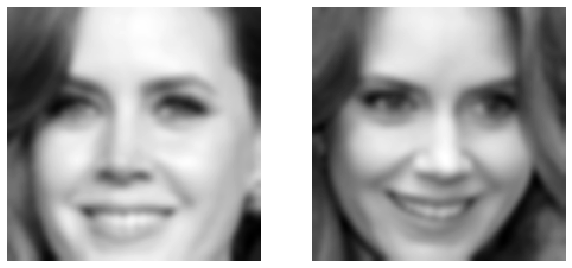

Example 1 Image Size: (214, 214) pixels
Example 2 Image Size: (214, 214) pixels


In [21]:
example_1 = face_dict[1][0]
example_2 = face_dict[1][1]

_ = compare_two_images(example_1, example_2)
print('Example 1 Image Size: {} pixels'.format(example_1.shape))
print('Example 2 Image Size: {} pixels'.format(example_2.shape))

---

Now that we have the ability to apply Gaussian blur across all the face images, let's test it out on our entire dataset.

In [22]:
preprocess_steps = [apply_blur, normalize_face_image_size]
pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1 = cross_validate(original_list, label_list, 
                                                                                         naive_lbph, character_dict,
                                                                                         preprocess_steps,
                                                                                         folds=3, random_state=42)

In [23]:
print("Average F1 Score from 3-Fold CV: {:.4f}".format(cv_average_f1))

Average F1 Score from 3-Fold CV: 0.3541


Yikes. Adding Gaussian blur made our classifier perform much worse. We can credit these issues to how the LBPH classifier defines one face from another. If you recall, the LBPH classifier takes center pixels and looks at the color intensity of all the surrounding pixels from that pixel to define an 8 bit number for that pixel. Performing this operation across all the pixels in the image generates a histogram distribution of values that images associated with that individual person is defined by.

Now, with Gaussian blur, you essentially smooth out the color intensity across the whole picture. The LBPH classifier is essentially an edge detector that's able to find points that define edges within an image. Similar edges yields similar people. Gaussian blur edits those edges to the point where the histogram distribution of the face images are different that the original face image. You lose much of the defining features that the LBPH classifier needs to classify people from one another which results in an accuracy loss as shown above.

## Augmenting Image Data

The last image preprocessing step we'll go over is image augmentation. Image augmentation is the act of taking the set of images you have and editing them slightly to create new images that you can use to train the classifier. Editing functions, for example, are zooming in on the face, tilting the face left and right, mirroring, etc. What's good about machine learning is that the classifier sees these slightly edited faces as completely new images with features that can be extracted and used to get a better sense of who that individual person is.

For this project, we use the ```Augmentor``` library (```pip install Augmentor```). The Augmentor library contains a host of different image editing functions that can be used for image augmentation.

The first function we use, ```make_training_directory```, takes the name of the character that we want to augment on and the root directory path and creates a new directory called ```training``` in that character's directory that we will use to store all the base images that we augment on.

The second function we use, ```augment_images```, creates a directory ```output``` within the character's training directory that stores all the image augmentations. Using an Augmentor pipeline, we randomize the chance between 25% and 75% that the image augmentation function will occur on the training image and store the image in the output directory. The use of these two functions are shown below.

In [24]:
import Augmentor
import shutil
import random

In [25]:
''' Create a clean training directory for the specified character '''

def make_training_directory(character, path):
    training_path = path + '/' + character + '/training'

    # Create a fresh training directory for each character
    try:
        _ = os.mkdir(training_path)
    except FileExistsError:
        _ = shutil.rmtree(training_path)
        _ = os.mkdir(training_path)
    
    return training_path

In [26]:
''' Apply Augmentor to images stored in project directory to generate num_samples more images'''

def augment_images(path_name, num_samples=100, random_state=None):
    random.seed(random_state)
    path_to_images = glob(path_name) 
    for path in path_to_images:

        # Delete output directories if they exist already
        output_path = path + '/output'
        try:
            shutil.rmtree(output_path)
        except FileNotFoundError:
            pass

        # Implement Augmentor pipeline to each character image directory w. random prob of each step occurring
        p = Augmentor.Pipeline(path)
        p.rotate(random.uniform(0.25, 0.75), max_left_rotation=10, max_right_rotation=10)
        p.shear(random.uniform(0.25, 0.75), max_shear_left=1, max_shear_right=0.01)
        p.shear(random.uniform(0.25, 0.75), max_shear_left=0.01, max_shear_right=1)
        p.flip_left_right(random.uniform(0.25, 0.75))
        
        # Create specified number of random samples
        _ = p.sample(num_samples)

Processing <PIL.Image.Image image mode=RGB size=233x283 at 0x7FEE403EDDA0>:  20%|██        | 2/10 [00:00<00:00, 31.22 Samples/s]                

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=259x408 at 0x7FEE403EDD68>: 100%|██████████| 10/10 [00:00<00:00, 12.61 Samples/s]               


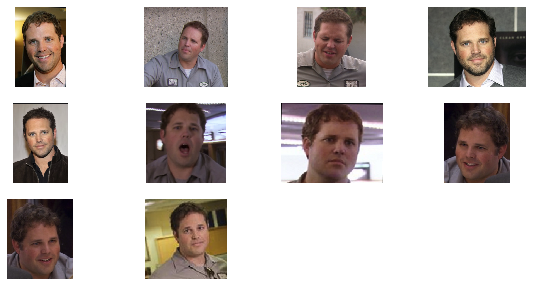

In [27]:
# Retrieve all the images from the project reference folder
character_dict, original_list, label_list = prepare_data('reference/7-Hyperparameter_Tuning/*/*.png', -2)

# Prepare original image dictionary using the prepare_image_dictionary function
img_dict, _ = prepare_image_dictionaries(original_list, label_list, preprocess_steps)

# Gather the image list and character name for the 0 index character
img_list = img_dict[0]
character = character_dict[0]

# Create training directory and save the training images to the directory
project_path = 'reference/7-Hyperparameter_Tuning'
training_path = make_training_directory(character, project_path)
for img_num, img in enumerate(img_list):
    img_path = '{}/{}.png'.format(training_path, img_num)
    _ = cv2.imwrite(img_path, img)

# Create 10 augmented images and store them in the created directory
_ = augment_images(training_path, num_samples=10, random_state=42)

# Gather all the augmented images from the output path in the training directory
glob_pattern = training_path + '/output/*.png'
img_path_list = glob(glob_pattern)
augment_list = []
for path in img_path_list:
    img = create_img(path)
    augment_list.append(img)

# Display the augmented images
_ = show_all_images(augment_list)

---

Now that we have functions to augment images in a provided directory, we'll edit the ```cross_validate``` function with a ```train_augment_test_split``` function that splits the image data by each character and stores the training images in the training directory for that character. The function then augments the images from the training directory and stores it in an output directory. It's very important to not augment the testing images since we're interested in testing the classifier on real-world face images.

We test this new ```cross_validate``` function by augmenting 100 new images from the training data and training our classifier on detected faces.

In [28]:
'''Perform a train-test split on the given ith-fold with image augmentation on training images'''

def train_augment_test_split(character_dict, project_path, data_dict, face_dict, i,
                             num_samples, folds, random_state=None):
    
    test_img_list = []
    test_label_list = np.array([])
    
    # Train-test split on each individual character
    for (label, img_list), (_, face_list) in zip(data_dict.items(), face_dict.items()):
        list_len = len(img_list)
        test_sample_len = int(1/folds * list_len)

        # Test Split on face images
        test_split = face_list[i*test_sample_len : (i+1)*test_sample_len]
        test_label_list = np.append(test_label_list, np.full(len(test_split), label))
        test_img_list = test_img_list + test_split

        # Train Split on original images
        train_split = img_list[:i*test_sample_len] + img_list[(i+1)*test_sample_len:]

        # Save training images to training directory
        character = character_dict[label]
        training_path = make_training_directory(character, project_path)
        for img_num, img in enumerate(train_split):
            img_path = '{}/{}.png'.format(training_path, img_num)
            _ = cv2.imwrite(img_path, img)

        # Augment the face images from the training directory and save augmentation to output directory
        _ = augment_images(training_path, num_samples, random_state)
    
    return test_img_list, test_label_list

In [29]:
''' Edit the CV function to save, augment, and train on the augmented training data images'''

def cross_validate(original_list, label_list, face_recognizer, character_dict, 
                    project_path, preprocess_steps=[normalize_face_image_size],
                       num_samples=100, folds=5, random_state=None):
    
    pred_face_list = []
    f1_average_list = []
    confusion_matrix_list = []
    pred_img_df_list = []
    
    # Shuffle the images
    cv_img_list, cv_label_list = shuffle_original(original_list, label_list, random_state)
    
    # Prepare an image dictionary with images where the LBPH could detect a face
    data_dict, original_face_dict = prepare_image_dictionaries(cv_img_list, cv_label_list, 
                                                               [normalize_face_image_size])
        
    for i in range(folds):
            
        test_img_list = train_face_list = []
        test_label_list = train_label_list = np.array([])
        
        # Augment the training data and create testing image data
        test_img_list, test_label_list = train_augment_test_split(character_dict,
                                                                  project_path,
                                                                  data_dict, 
                                                                  original_face_dict, i,
                                                                  num_samples, 
                                                                  folds, random_state)
            
        # Retrieve augmented image data for training the classifier
        training_img_path = project_path + '/*/training/output/*.png' 
        _, train_img_list, train_label_list = prepare_data(training_img_path, -4)
        
        # Gather grayscale face images from augmented training data
        _, face_dict = prepare_image_dictionaries(train_img_list, train_label_list, preprocess_steps)
        
        # Generate the final training faces and labels from the face_dict
        train_label_list = np.array([])
        for (label, face_list) in face_dict.items():
            train_label_list = np.append(train_label_list, np.full(len(face_list), label))
            train_face_list = train_face_list + face_list
            
        # Cast training label list as integer list and train the classifier
        train_label_list = train_label_list.astype(int)
        face_recognizer.train(train_face_list, train_label_list)
        
        
        # Generate the confusion matrix by predicting test images
        confusion_matrix, pred_img_df = generate_confusion_matrix(character_dict, test_img_list, test_label_list, 
                                                                  face_recognizer)
        confusion_matrix_list.append(confusion_matrix)
        pred_img_df_list.append(pred_img_df)
        
        # Gather f1 score information from data gathered in testing phase
        f1_score_list = generate_f1_scores(confusion_matrix, character_dict)
        character_average_f1 = np.mean(f1_score_list)
        f1_average_list.append(character_average_f1)
        
    # Average the f1 scores together
    cv_average_f1 = np.mean(f1_average_list)
    
    return pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1

In [30]:
''' Cross-Validation Preparation '''

character_dict, original_list, label_list = prepare_data('reference/7-Hyperparameter_Tuning/*/*.png', -2)
face_recognizer = cv2.face.LBPHFaceRecognizer_create()
preprocess_steps = [normalize_face_image_size]
project_path = 'reference/7-Hyperparameter_Tuning'

In [31]:
pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1 = cross_validate(original_list, label_list, 
                                                                                         face_recognizer, 
                                                                                         character_dict, 
                                                                                         project_path,
                                                                                         preprocess_steps,
                                                                                         num_samples=100,
                                                                                         folds=3, random_state=42)

Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=207x245 at 0x7FEE40B27B00>: 100%|██████████| 100/100 [00:01<00:00, 59.59 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=171x193 at 0x7FEE458704A8>: 100%|██████████| 100/100 [00:00<00:00, 151.19 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=241x321 at 0x7FEE4584F860>: 100%|██████████| 100/100 [00:04<00:00, 21.83 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=453x547 at 0x7FEE4584F978>: 100%|██████████| 100/100 [00:01<00:00, 54.72 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=196x244 at 0x7FEE3FBFECC0>: 100%|██████████| 100/100 [00:01<00:00, 52.90 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=233x283 at 0x7FEE45866978>: 100%|██████████| 100/100 [00:02<00:00, 47.73 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=191x163 at 0x7FEE40B5C198>: 100%|██████████| 100/100 [00:02<00:00, 49.47 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=818x1134 at 0x7FEE40AF99E8>: 100%|██████████| 100/100 [00:02<00:00, 35.46 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=334x414 at 0x7FEE40AF9160>: 100%|██████████| 100/100 [00:01<00:00, 60.51 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 15 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=363x433 at 0x7FEE4587B588>: 100%|██████████| 100/100 [00:03<00:00, 25.85 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=1090x1056 at 0x7FEE40B5C908>: 100%|██████████| 100/100 [00:04<00:00, 23.71 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=972x994 at 0x7FEE40B3FBE0>: 100%|██████████| 100/100 [00:03<00:00, 25.78 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=315x403 at 0x7FEE458F7748>: 100%|██████████| 100/100 [00:03<00:00, 29.47 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=188x227 at 0x7FEE40B27828>: 100%|██████████| 100/100 [00:00<00:00, 146.02 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=460x530 at 0x7FEE4584F160>: 100%|██████████| 100/100 [00:00<00:00, 130.79 Samples/s]              
Processing <PIL.Image.Image image mode=RGB size=223x319 at 0x7FEE45870C18>:   1%|          | 1/100 [00:00<00:18,  5.25 Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=311x468 at 0x7FEE458E9630>: 100%|██████████| 100/100 [00:00<00:00, 243.57 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=151x165 at 0x7FEE4587BEB8>: 100%|██████████| 100/100 [00:00<00:00, 137.56 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 9 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=477x631 at 0x7FEE40B3FF98>: 100%|██████████| 100/100 [00:00<00:00, 174.56 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=198x230 at 0x7FEE458D2F28>: 100%|██████████| 100/100 [00:02<00:00, 47.97 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=171x193 at 0x7FEE40B27710>: 100%|██████████| 100/100 [00:01<00:00, 86.08 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=241x321 at 0x7FEE40B477B8>: 100%|██████████| 100/100 [00:04<00:00, 24.57 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=578x738 at 0x7FEE40AF9780>: 100%|██████████| 100/100 [00:02<00:00, 48.98 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=196x244 at 0x7FEE458EFEF0>: 100%|██████████| 100/100 [00:01<00:00, 64.93 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=144x157 at 0x7FEE458D2320>: 100%|██████████| 100/100 [00:01<00:00, 59.96 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x560 at 0x7FEE40B33C50>: 100%|██████████| 100/100 [00:01<00:00, 59.37 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=335x378 at 0x7FEE4587BF98>: 100%|██████████| 100/100 [00:03<00:00, 29.22 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=138x179 at 0x7FEE4588C5F8>: 100%|██████████| 100/100 [00:01<00:00, 51.46 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 15 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=363x433 at 0x7FEE40B27B70>: 100%|██████████| 100/100 [00:03<00:00, 25.98 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=153x243 at 0x7FEE40AEC198>: 100%|██████████| 100/100 [00:02<00:00, 33.38 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=972x994 at 0x7FEE4588CE10>: 100%|██████████| 100/100 [00:03<00:00, 25.49 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x466 at 0x7FEE40AF9E10>: 100%|██████████| 100/100 [00:02<00:00, 38.44 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=188x227 at 0x7FEE458D25C0>:   3%|▎         | 3/100 [00:00<00:17,  5.41 Samples/s]                

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=188x227 at 0x7FEE458EFCF8>: 100%|██████████| 100/100 [00:00<00:00, 228.27 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=460x530 at 0x7FEE40B4E860>: 100%|██████████| 100/100 [00:00<00:00, 111.88 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=311x468 at 0x7FEE458C4358>: 100%|██████████| 100/100 [00:00<00:00, 230.59 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=160x155 at 0x7FEE4588CA58>: 100%|██████████| 100/100 [00:01<00:00, 81.81 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 9 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=477x631 at 0x7FEE45870748>: 100%|██████████| 100/100 [00:00<00:00, 169.13 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=198x230 at 0x7FEE40AF9BA8>: 100%|██████████| 100/100 [00:01<00:00, 52.63 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=171x193 at 0x7FEE40B5CD30>: 100%|██████████| 100/100 [00:01<00:00, 98.57 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=241x321 at 0x7FEE4584F048>: 100%|██████████| 100/100 [00:04<00:00, 22.53 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=578x738 at 0x7FEE4588CE10>: 100%|██████████| 100/100 [00:01<00:00, 68.22 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=196x244 at 0x7FEE4587BEB8>: 100%|██████████| 100/100 [00:01<00:00, 85.48 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=144x157 at 0x7FEE458E99E8>: 100%|██████████| 100/100 [00:01<00:00, 79.52 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x560 at 0x7FEE40AF97B8>: 100%|██████████| 100/100 [00:02<00:00, 47.24 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=335x378 at 0x7FEE4588C550>: 100%|██████████| 100/100 [00:03<00:00, 27.49 Samples/s] 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=138x179 at 0x7FEE45935A90>: 100%|██████████| 100/100 [00:01<00:00, 58.93 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 15 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x884 at 0x7FEE4587BD30>: 100%|██████████| 100/100 [00:03<00:00, 32.18 Samples/s] 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=153x243 at 0x7FEE4592E358>: 100%|██████████| 100/100 [00:04<00:00, 24.26 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=371x413 at 0x7FEE4588C128>: 100%|██████████| 100/100 [00:03<00:00, 27.51 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=422x466 at 0x7FEE4592EBE0>: 100%|██████████| 100/100 [00:02<00:00, 35.90 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=213x210 at 0x7FEE458EFC18>: 100%|██████████| 100/100 [00:00<00:00, 143.07 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=199x188 at 0x7FEE45935400>: 100%|██████████| 100/100 [00:00<00:00, 117.64 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=259x310 at 0x7FEE45885DA0>: 100%|██████████| 100/100 [00:00<00:00, 232.34 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=160x155 at 0x7FEE4592E978>: 100%|██████████| 100/100 [00:01<00:00, 86.93 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=161x180 at 0x7FEE458EF6D8>:   6%|▌         | 6/100 [00:00<00:13,  7.20 Samples/s]                

Initialised with 9 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=161x180 at 0x7FEE4592E7B8>: 100%|██████████| 100/100 [00:00<00:00, 325.47 Samples/s]


In [32]:
print("Average F1 Score from 3-Fold CV: {:.4f}".format(cv_average_f1))

Average F1 Score from 3-Fold CV: 0.6952


The LBPH classifier improved by quite a bit given more training data. Image augmentation is a useful tool since we can expand our training dataset without actually having to find new pictures of characters from <i>The Office</i>. With 3-Fold cross-validation, an F1 score of 0.6952 is significantly better than our previous best of 0.5649.

## Uniform Training and Testing Grayscale Face Image Size

As we learned before, having an equal image size on training improves the performance of the classifier when testing on new images. Since rescaling the training images removes much of the variance caused by having different image sizes, by the same principle, we should see improvements by rescaling the testing face image data to the same size before making our predictions. The results are shown below.

In [33]:
''' Edit the CV function to save, augment, and train on the augmented training data images'''

def cross_validate(original_list, label_list, face_recognizer, character_dict, 
                    project_path, preprocess_steps=[normalize_face_image_size],
                       num_samples=100, folds=5, random_state=None):
    
    pred_img_df_list = []
    confusion_matrix_list = []
    f1_average_list = []
    
    # Shuffle the images
    cv_img_list, cv_label_list = shuffle_original(original_list, label_list, random_state)
    
    # Prepare an image dictionary with images where the LBPH could detect a face
    data_dict, original_face_dict = prepare_image_dictionaries(cv_img_list, 
                                                               cv_label_list, 
                                                               [normalize_face_image_size])
        
    for i in range(folds):
            
        train_face_list = []
        train_label_list = np.array([])
        
        # Augment the training data and create testing image data
        test_img_list, test_label_list = train_augment_test_split(character_dict,
                                                                  project_path,
                                                                  data_dict, 
                                                                  original_face_dict, i,
                                                                  num_samples, 
                                                                  folds, random_state)
            
        # Retrieve augmented image data for training the classifier
        training_img_path = project_path + '/*/training/output/*.png' 
        _, train_img_list, train_label_list = prepare_data(training_img_path, -4)
        
        # Gather grayscale face images from augmented training data
        _, augment_face_dict = prepare_image_dictionaries(train_img_list, 
                                                       train_label_list, 
                                                       preprocess_steps)
        
        # Resize the augmented face images to be the same size as the testing face images from original_face_dict
        dim = original_face_dict[0][0].shape
        for key, face_list in augment_face_dict.items():
            resized_face_list = []
            for face in face_list:
                resized = cv2.resize(face, dim)
                resized_face_list.append(resized)
            augment_face_dict[key] = resized_face_list
        
        # Generate the final training faces and labels from the face_dict
        train_label_list = np.array([])
        for (label, face_list) in augment_face_dict.items():
            train_label_list = np.append(train_label_list, np.full(len(face_list), label))
            train_face_list = train_face_list + face_list
        
        # Cast training label list as integer list and train the classifier
        train_label_list = train_label_list.astype(int)
        face_recognizer.train(train_face_list, train_label_list)
        
        # Generate the confusion matrix by predicting test images
        confusion_matrix, pred_img_df = generate_confusion_matrix(character_dict, test_img_list, test_label_list, 
                                                                  face_recognizer)
        confusion_matrix_list.append(confusion_matrix)
        pred_img_df_list.append(pred_img_df)
        
        # Gather f1 score information from data gathered in testing phase
        f1_score_list = generate_f1_scores(confusion_matrix, character_dict)
        character_average_f1 = np.mean(f1_score_list)
        f1_average_list.append(character_average_f1)
        
    # Average the f1 scores together
    cv_average_f1 = np.mean(f1_average_list)
    
    return pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1

In [34]:
pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1 = cross_validate(original_list, label_list, 
                                                                                         face_recognizer, 
                                                                                         character_dict, 
                                                                                         project_path,
                                                                                         preprocess_steps,
                                                                                         num_samples=100,
                                                                                         folds=3, random_state=42)

Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=207x245 at 0x7FEE45935828>: 100%|██████████| 100/100 [00:01<00:00, 69.18 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=171x193 at 0x7FEE4587B0B8>: 100%|██████████| 100/100 [00:00<00:00, 136.45 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=241x321 at 0x7FEE45885A90>: 100%|██████████| 100/100 [00:04<00:00, 23.07 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=453x547 at 0x7FEE45870630>: 100%|██████████| 100/100 [00:01<00:00, 53.61 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=196x244 at 0x7FEE4592EEF0>: 100%|██████████| 100/100 [00:01<00:00, 54.68 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=233x283 at 0x7FEE459206D8>: 100%|██████████| 100/100 [00:02<00:00, 47.25 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=191x163 at 0x7FEE4588CBA8>: 100%|██████████| 100/100 [00:02<00:00, 46.26 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=818x1134 at 0x7FEE4587F358>: 100%|██████████| 100/100 [00:02<00:00, 34.19 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=334x414 at 0x7FEE459204E0>: 100%|██████████| 100/100 [00:01<00:00, 55.08 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 15 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=363x433 at 0x7FEE4587BC18>: 100%|██████████| 100/100 [00:03<00:00, 27.05 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1090x1056 at 0x7FEE45935080>: 100%|██████████| 100/100 [00:04<00:00, 24.15 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=972x994 at 0x7FEE458C48D0>: 100%|██████████| 100/100 [00:03<00:00, 26.53 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=315x403 at 0x7FEE45885748>: 100%|██████████| 100/100 [00:03<00:00, 29.37 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=188x227 at 0x7FEE4587FFD0>: 100%|██████████| 100/100 [00:00<00:00, 150.09 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=460x530 at 0x7FEE3FD65400>: 100%|██████████| 100/100 [00:00<00:00, 137.99 Samples/s]              
Processing <PIL.Image.Image image mode=RGB size=201x189 at 0x7FEE458E9C18>:   3%|▎         | 3/100 [00:00<00:16,  5.96 Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=311x468 at 0x7FEE40B4E940>: 100%|██████████| 100/100 [00:00<00:00, 234.78 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=151x165 at 0x7FEE40B5C9B0>: 100%|██████████| 100/100 [00:00<00:00, 134.47 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 9 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=477x631 at 0x7FEE458E9AC8>: 100%|██████████| 100/100 [00:00<00:00, 170.58 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=198x230 at 0x7FEE45920160>: 100%|██████████| 100/100 [00:02<00:00, 47.06 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=171x193 at 0x7FEE4587FE48>: 100%|██████████| 100/100 [00:01<00:00, 83.10 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=241x321 at 0x7FEE4592EEB8>: 100%|██████████| 100/100 [00:04<00:00, 24.57 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=578x738 at 0x7FEE45870BE0>: 100%|██████████| 100/100 [00:01<00:00, 52.13 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=196x244 at 0x7FEE45870908>: 100%|██████████| 100/100 [00:01<00:00, 68.24 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=144x157 at 0x7FEE458C4C88>: 100%|██████████| 100/100 [00:01<00:00, 52.00 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x560 at 0x7FEE4587FE80>: 100%|██████████| 100/100 [00:01<00:00, 58.60 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=335x378 at 0x7FEE40AF9588>: 100%|██████████| 100/100 [00:03<00:00, 28.94 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=138x179 at 0x7FEE459204E0>: 100%|██████████| 100/100 [00:01<00:00, 54.15 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 15 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=363x433 at 0x7FEE40AEC160>: 100%|██████████| 100/100 [00:04<00:00, 23.95 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=153x243 at 0x7FEE4587BF60>: 100%|██████████| 100/100 [00:03<00:00, 32.43 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=972x994 at 0x7FEE45870748>: 100%|██████████| 100/100 [00:03<00:00, 26.72 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x466 at 0x7FEE45920588>: 100%|██████████| 100/100 [00:02<00:00, 38.37 Samples/s]
Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=188x227 at 0x7FEE4584FCF8>:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=188x227 at 0x7FEE45907278>: 100%|██████████| 100/100 [00:00<00:00, 191.58 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=460x530 at 0x7FEE4584FBA8>: 100%|██████████| 100/100 [00:00<00:00, 116.49 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=311x468 at 0x7FEE45907F60>: 100%|██████████| 100/100 [00:00<00:00, 220.34 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=160x155 at 0x7FEE458D29B0>: 100%|██████████| 100/100 [00:01<00:00, 78.73 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 9 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=477x631 at 0x7FEE403EDCC0>: 100%|██████████| 100/100 [00:00<00:00, 165.66 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=198x230 at 0x7FEE3FE07588>: 100%|██████████| 100/100 [00:01<00:00, 51.54 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=171x193 at 0x7FEE458EF5C0>: 100%|██████████| 100/100 [00:01<00:00, 97.55 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=241x321 at 0x7FEE45885D68>: 100%|██████████| 100/100 [00:04<00:00, 22.03 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=578x738 at 0x7FEE458C4BA8>: 100%|██████████| 100/100 [00:01<00:00, 68.57 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=196x244 at 0x7FEE4588CF28>: 100%|██████████| 100/100 [00:01<00:00, 76.72 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=144x157 at 0x7FEE4587B470>: 100%|██████████| 100/100 [00:01<00:00, 78.40 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x560 at 0x7FEE3FE070F0>: 100%|██████████| 100/100 [00:02<00:00, 43.43 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=335x378 at 0x7FEE3FE07908>: 100%|██████████| 100/100 [00:03<00:00, 26.74 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=138x179 at 0x7FEE4587F828>: 100%|██████████| 100/100 [00:01<00:00, 60.94 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 15 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=768x884 at 0x7FEE458C4438>: 100%|██████████| 100/100 [00:03<00:00, 30.42 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=153x243 at 0x7FEE4588CE80>: 100%|██████████| 100/100 [00:03<00:00, 26.13 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=371x413 at 0x7FEE45870EF0>: 100%|██████████| 100/100 [00:03<00:00, 28.32 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x466 at 0x7FEE3FD7D240>: 100%|██████████| 100/100 [00:02<00:00, 35.17 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=213x210 at 0x7FEE45885860>: 100%|██████████| 100/100 [00:00<00:00, 144.12 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=199x188 at 0x7FEE45894748>: 100%|██████████| 100/100 [00:00<00:00, 135.37 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=259x310 at 0x7FEE45907F28>: 100%|██████████| 100/100 [00:00<00:00, 222.33 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x155 at 0x7FEE4587F7B8>: 100%|██████████| 100/100 [00:01<00:00, 83.68 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=161x186 at 0x7FEE45885940>:   7%|▋         | 7/100 [00:00<00:12,  7.71 Samples/s]                

Initialised with 9 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=161x180 at 0x7FEE458EF860>: 100%|██████████| 100/100 [00:00<00:00, 341.81 Samples/s]              


In [35]:
print("Average F1 Score from 3-Fold CV: {:.4f}".format(cv_average_f1))

Average F1 Score from 3-Fold CV: 0.7054


Rescaling the testing images shows a marginal improvement over making predictions on unedited face image data. 0.7054 is the best facial recognition performance we have on our 18 character dataset so far. These marginal improvements are good, but what if there was a better way than LBPH Facial Recognition that could improve our model's performance to near 100%? <b>Enter, FaceNet<b>.

## FaceNet

FaceNet is a technology founded by Google researchers Florian Schroff, Dmitry Kalenichenko, James Philbin in 2015 (1). These researchers developed a novel approach to facial classification that improved image to identity matching by a factor of 30% over the former state-of-the-art DeepId2+ classification model.

The researchers accomplished this task by creating a convolutional neural network approach to a triplet loss function. The triplet loss function, as described in the researchers' paper, is a function that distinguishes 2 images of the same person from 1 image of a different person. During training, the function learns how to embed vectors of all three images where vectors for images of the same person are geometrically closer to one another than the vector of the different person. This vector embedding process can then be generalized to any face image provided as input to the CNN where images of the same person are mapped geometrically further than all other identities.

The implementation of FaceNet that we use for this project takes a 160x160 pixel color face image at the input layer and runs it through 20 hidden layers that consists of convolutional layers, pooling layers, and batch norm layers. The classifier returns a 128-D floating point vector at the output layer that represents an embedding for the face provided. 

The validation score used to judge the performance of the classifier is defined as the ratio between true accepts over the number of provided images for that person; the classifier's recall ability. Using the faces defined in Youtube Faces DB which contains facial video data of 1595 different people, the classifier scored a validation score of <b><i>95.43%!!!</i></b>

With such a good score on nearly 100 times more people than characters in <i>The Office</i>, it would be valuable to implement FaceNet for this project. Thankfully, we can. Hiroki Taniai from the University of Tokyo took Schroff et al.'s FaceNet CNN architechture and built it using tensorflow and keras (2). Taniai trained the CNN on the MS-Celeb-1M dataset and provided the model weights from the network in the form of an HDF5 formatted file. By utilizing transfer learning, we can take Taniai's pretrained model and make classification predictions on our own dataset for characters in <i>The Office</i>.    

<figure>
<img src="https://pbs.twimg.com/media/DYB68AIWkAEevws.jpg" alt="Scranton Strangler" class="center" style=width:205;height:350px;>

<figcaption><center><b>Despite the classifier's performance, it can't identify the Scranton Strangler...</b></center></figcaption>

</figure> 

---

The first function we need to make is ```embed_face```. This function first takes the face image data of a given image and rescales it to 160x160 pixels and standardizes the pixel data values to have a mean of 0 and and a standard deviation of 1. It then uses the ```keras.models``` predict function to run the pre-trained classifier's weights on the 160x160 pixel face image data to create the 128-D output vector.

The second function we work on is ```generate_confusion_matrix```. To recap, ```generate_confusion_matrix``` runs predictions on the testing dataset and stores the predictions in an object DataFrame called ```pred_img_df```. Since we're running predictions on 128-D vectors as opposed to face images of varying size, we need to edit this function to accept the new testing dataset format for predictions.

Lastly, we edit the ```cross-validate``` function to tie everything together. After image augmentation, we detect faces from these training images. Then, we embed the face image data from the training and testing sets into 128D FaceNet vectors and store them in numpy arrays. Next, we normalize the vectors using the L2 distance so the length of all the 128D vectors is equal to 1. Lastly, we model the training vectors and labels using a Support Vector Machine (SVM). 

An SVM generates decision boundaries between vectors that defines a space that corresponds to a class. The SVM defines margins where vectors that lie within that margin can be classified as a point on the opposite side of the boundary.

Facial classification happens during the SVM stage. The SVM is trained on vectors and labels provided in the training set and makes predictions on vectors in the testing set. The labels generated from the testing set predictions are then compared to their actual labels. Using ```generate_confusion_matrix```, we can then see what face images were classified as and the confusion matrix overview of the SVM classifier on embedded vectors.

---

In [36]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer

Using TensorFlow backend.


In [37]:
'''
The model provided for face embedding will be the FaceNet model generated by Hiroi Taniai.
The output is a 128-D embedding vector of the face provided
'''
def embed_face(face, model, required_size=(160,160)):
    
    # Turn grayscale face into RGB acceptable format for FaceNet model
    if face.shape[-1] != 3:
        img = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    
    # Resize the face image to the required 160x160 FaceNet image size    
    img = cv2.resize(img, required_size)
    img = img.astype('float32')
    
    # Standardize the pixel values
    mean, std = img.mean(), img.std()
    img = (img - mean) / std
    
    # Turn the processed face into a sample that can be used for embedding
    sample = np.expand_dims(img, axis=0)
    
    # Embed the face to a 128 element vector using the FaceNet model
    embedding = model.predict(sample)
    
    # Return the embedded vector
    return embedding[0]

In [38]:
''' Edit the generate_confusion_matrix function to work with image embeddings from FaceNet 
    (changes provided in else-statement)
'''

def generate_confusion_matrix(character_dict, test_img_list, test_label_list, 
                              face_recognizer, test_X=None, test_y=None):
    
    # Generate initial confusion matrix DataFrame
    character_list = []
    for _, character in character_dict.items():
        character_list.append(character)
    
    confusion_matrix = pd.DataFrame(index=character_list, columns=character_list)
    confusion_matrix.loc[:, :] = 0
    
    pred_img_df = pd.DataFrame(index=character_list, columns=character_list).astype('object')
    for i in range(pred_img_df.shape[0]):
        for j in range(pred_img_df.shape[1]):
            pred_img_df.iloc[i, j] = []
    
    # Make predictions on test images
    if (test_X is None) and (test_y is None):
        for test_img, true_label in zip(test_img_list, test_label_list):

            # What to do if the test images are in color 
            if (test_img.shape[-1] == 3):
                # Make prediction on test image and add to pred_face_list
                pred_label_list, pred_rect_list = predict(test_img, face_recognizer)

                if pred_rect_list is not None:
                    pred_img = draw_character_labels(test_img, character_dict, 
                                                     pred_label_list, pred_rect_list)

                # Populate confusion matrix based on prediction
                actual_character = character_dict[true_label]
                pred_character = character_dict[pred_label_list[0]]

                confusion_matrix.loc[pred_character, actual_character] += 1
                pred_img_df.loc[pred_character, actual_character].append(pred_img)

            # What to do if the test image is in grayscale
            else:
                # Predict on the grayscale face provided
                pred_label = face_recognizer.predict(test_img)

                # Populate confusion matrix based on prediction
                actual_character = character_dict[true_label]
                pred_character = character_dict[pred_label[0]]

                confusion_matrix.loc[pred_character, actual_character] += 1
                pred_img_df.loc[pred_character, actual_character].append(test_img)
    
    # Make prediction on image vectors
    else:
        
        # Predict on the testing image set
        pred_y = face_recognizer.predict(test_X)
        
        for ((idx, pred_label), true_label) in zip(enumerate(pred_y), test_y):
            
            # Add point to confusion matrix
            pred_character = character_dict[pred_label]
            actual_character = character_dict[true_label]
            confusion_matrix.loc[pred_character, actual_character] += 1
            
            # Add test image to DataFrame
            img = test_img_list[idx].copy()
            pred_img_df.loc[pred_character, actual_character].append(img)
    
    return confusion_matrix, pred_img_df

In [39]:
''' Edit the CV function to work on image embeddings (face_recognizer takes on the form of FaceNet model)'''

def cross_validate(original_list, label_list, face_recognizer, character_dict, 
                    project_path, preprocess_steps=[normalize_face_image_size],
                       num_samples=100, folds=5, random_state=None):
    
    pred_img_df_list = []
    confusion_matrix_list = []
    f1_average_list = []
    t_list = []
    
    # Shuffle the images
    cv_img_list, cv_label_list = shuffle_original(original_list, label_list, random_state)
    
    # Prepare an image dictionary with images where the LBPH could detect a face
    data_dict, original_face_dict = prepare_image_dictionaries(cv_img_list, 
                                                               cv_label_list, 
                                                               [])
        
    for i in range(folds):
            
        # Augment the training data and create testing image data
        test_face_list, test_label_list = train_augment_test_split(character_dict,
                                                                  project_path,
                                                                  data_dict, 
                                                                  original_face_dict, i,
                                                                  num_samples, 
                                                                  folds, random_state)
            
        # Retrieve augmented image data for training the classifier
        training_img_path = project_path + '/*/training/output/*.png' 
        _, train_img_list, train_label_list = prepare_data(training_img_path, -4)
        
        # Gather faces from augmented training data
        _, augment_face_dict = prepare_image_dictionaries(train_img_list, 
                                                       train_label_list, 
                                                       preprocess_steps)
        
        # Convert the training faces to 128-element embedded FaceNet vectors
        embed_augment_face_dict = defaultdict(list)
        for key, face_list in augment_face_dict.items():
            embedding_face_list = []
            for face in face_list:
                if face is None or face.shape[0] == 0 or face.shape[1] == 0:
                    continue
                embedding = embed_face(face, face_recognizer)
                embedding_face_list.append(embedding)
            embed_augment_face_dict[key] = embedding_face_list
        
        
        # Convert the testing faces to 128-element embedded FaceNet vectors
        test_face_dict = defaultdict(list)
        for img, label in zip(test_face_list, test_label_list):
            test_face_dict[label].append(img)
        embed_test_face_dict = defaultdict(list)
        test_face_list = []
        test_face_label_list = np.array([])
        for label, face_list in test_face_dict.items():
            embedding_face_list = []
            for face in face_list:
                if face is None or face.shape[0] == 0 or face.shape[1] == 0:
                    continue
                embedding = embed_face(face, face_recognizer)
                embedding_face_list.append(embedding)
                test_face_list.append(face)
                test_face_label_list = np.append(test_face_label_list, label)
            embed_test_face_dict[label] = embedding_face_list

        
        # Generate the final training embedding list and labels from embed_augment_face_dict
        train_X = []
        train_y = np.array([])
        for (label, embed_list) in embed_augment_face_dict.items():
            for embed in embed_list:
                train_X.append(embed)
            train_y = np.append(train_y, np.full(len(embed_list), label))
        train_X = np.asarray(train_X)
        
        # Generate the final testing embedding list and labels from the embed_test_face_dict
        test_X = []
        test_y = np.array([])
        for (label, embed_list) in embed_test_face_dict.items():
            for embed in embed_list:
                test_X.append(embed)
            test_y = np.append(test_y, np.full(len(embed_list), label))
        test_X = np.asarray(test_X)
        
        
        # Cast training label list as integer list and train the classifier
        train_y = train_y.astype(int)
        test_y = test_y.astype(int)
        
        # Normalize input vectors
        norm = Normalizer(norm='l2')
        train_X = norm.transform(train_X)
        test_X = norm.transform(test_X)
        
        # Train a linear SVM for facial recognition
        model = SVC(kernel='linear')
        model.fit(train_X, train_y)
        
        # Generate the confusion matrix by predicting test images
        confusion_matrix, pred_img_df = generate_confusion_matrix(character_dict, 
                                                                  test_face_list, test_face_label_list, 
                                                                  model, test_X, test_y)
        confusion_matrix_list.append(confusion_matrix)
        pred_img_df_list.append(pred_img_df)
        
        # Gather f1 score information from data gathered in testing phase
        f1_score_list = generate_f1_scores(confusion_matrix, character_dict)
        character_average_f1 = np.mean(f1_score_list)
        f1_average_list.append(character_average_f1)
        t_list.append(test_face_list)
        
    # Average the f1 scores together
    cv_average_f1 = np.mean(f1_average_list)
    
    return pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1, t_list

In [40]:
character_dict, original_list, label_list = prepare_data('reference/7-Hyperparameter_Tuning/*/*.png', -2)
feature_extractor = load_model('facenet_keras.h5')
preprocess_steps = []
project_path = 'reference/7-Hyperparameter_Tuning'








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/media/qiujing/e5439522-63c4-4b7c-a968-fefee6a3d960/omead/anaconda3/envs/face_project/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [41]:
pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1, t_list = cross_validate(original_list, 
                                                                                         label_list, 
                                                                                         feature_extractor, 
                                                                                         character_dict, 
                                                                                         project_path, 
                                                                                         preprocess_steps, 
                                                                                         num_samples=100, folds=3, 
                                                                                         random_state=42)

Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=207x245 at 0x7FEC7AA2B198>: 100%|██████████| 100/100 [00:01<00:00, 65.15 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=171x193 at 0x7FEC7AB47F98>: 100%|██████████| 100/100 [00:00<00:00, 140.17 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=241x321 at 0x7FEC7A770320>: 100%|██████████| 100/100 [00:04<00:00, 21.03 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=453x547 at 0x7FEC7A2C7C88>: 100%|██████████| 100/100 [00:01<00:00, 51.13 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=196x244 at 0x7FEC7A2DC400>: 100%|██████████| 100/100 [00:01<00:00, 53.41 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=233x283 at 0x7FEC7A485B70>: 100%|██████████| 100/100 [00:02<00:00, 45.61 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=191x163 at 0x7FEC7A2DC208>: 100%|██████████| 100/100 [00:01<00:00, 50.87 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=818x1134 at 0x7FEC7AAE0198>: 100%|██████████| 100/100 [00:02<00:00, 35.95 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=334x414 at 0x7FEC7A2DC4A8>: 100%|██████████| 100/100 [00:01<00:00, 56.57 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 15 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=363x433 at 0x7FEC7AB5E748>: 100%|██████████| 100/100 [00:04<00:00, 24.94 Samples/s] 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=1090x1056 at 0x7FEC7AAB98D0>: 100%|██████████| 100/100 [00:04<00:00, 24.38 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=972x994 at 0x7FEC7A70F2E8>: 100%|██████████| 100/100 [00:03<00:00, 25.42 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=315x403 at 0x7FED6440C278>: 100%|██████████| 100/100 [00:03<00:00, 27.04 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=188x227 at 0x7FEC7ABC5320>: 100%|██████████| 100/100 [00:00<00:00, 143.36 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=460x530 at 0x7FEC7A646CC0>: 100%|██████████| 100/100 [00:00<00:00, 139.06 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=311x468 at 0x7FEC7A30A2B0>: 100%|██████████| 100/100 [00:00<00:00, 210.27 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=151x165 at 0x7FEC7A5EF2E8>: 100%|██████████| 100/100 [00:00<00:00, 130.48 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 9 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=477x631 at 0x7FEC7A34DC50>: 100%|██████████| 100/100 [00:00<00:00, 165.67 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=198x230 at 0x7FED644241D0>: 100%|██████████| 100/100 [00:02<00:00, 49.06 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=171x193 at 0x7FEC7A7B0588>: 100%|██████████| 100/100 [00:01<00:00, 90.23 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=241x321 at 0x7FEC7A2C7668>: 100%|██████████| 100/100 [00:04<00:00, 23.40 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=578x738 at 0x7FEC7A289C50>: 100%|██████████| 100/100 [00:02<00:00, 49.22 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=196x244 at 0x7FED66057128>: 100%|██████████| 100/100 [00:01<00:00, 74.05 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=144x157 at 0x7FEC7A2DCDA0>: 100%|██████████| 100/100 [00:01<00:00, 55.76 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x560 at 0x7FEE45843518>: 100%|██████████| 100/100 [00:01<00:00, 58.45 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=335x378 at 0x7FEC7A2632E8>: 100%|██████████| 100/100 [00:03<00:00, 28.01 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=138x179 at 0x7FEC7AA9F160>: 100%|██████████| 100/100 [00:02<00:00, 48.54 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 15 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=363x433 at 0x7FEC7AA57F98>: 100%|██████████| 100/100 [00:03<00:00, 26.06 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=153x243 at 0x7FEC7A296E10>: 100%|██████████| 100/100 [00:03<00:00, 31.90 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=972x994 at 0x7FEC7AAB98D0>: 100%|██████████| 100/100 [00:03<00:00, 25.34 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=422x466 at 0x7FEC7AACEA58>: 100%|██████████| 100/100 [00:02<00:00, 35.30 Samples/s]                
Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=188x227 at 0x7FEC7A53BCC0>:   1%|          | 1/100 [00:00<00:18,  5.38 Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=188x227 at 0x7FEC7A646AC8>: 100%|██████████| 100/100 [00:00<00:00, 219.06 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=460x530 at 0x7FEC7A84CC50>: 100%|██████████| 100/100 [00:00<00:00, 110.01 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=311x468 at 0x7FEC7A8ED898>: 100%|██████████| 100/100 [00:00<00:00, 203.57 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=160x155 at 0x7FEC7A485CF8>: 100%|██████████| 100/100 [00:01<00:00, 84.87 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 9 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=477x631 at 0x7FEC7A2C7EF0>: 100%|██████████| 100/100 [00:00<00:00, 160.74 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=198x230 at 0x7FED6441CD68>: 100%|██████████| 100/100 [00:01<00:00, 50.71 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=171x193 at 0x7FED64424208>: 100%|██████████| 100/100 [00:00<00:00, 112.23 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=241x321 at 0x7FEC7A7B02B0>: 100%|██████████| 100/100 [00:04<00:00, 21.21 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=578x738 at 0x7FED644240B8>: 100%|██████████| 100/100 [00:01<00:00, 70.36 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=196x244 at 0x7FEC7AA7D6A0>: 100%|██████████| 100/100 [00:01<00:00, 78.46 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=144x157 at 0x7FEC7A4F74E0>: 100%|██████████| 100/100 [00:01<00:00, 71.39 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x560 at 0x7FEC7A26DA90>: 100%|██████████| 100/100 [00:02<00:00, 46.35 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=335x378 at 0x7FEC7A272AC8>: 100%|██████████| 100/100 [00:03<00:00, 25.69 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=138x179 at 0x7FEC7A28E080>: 100%|██████████| 100/100 [00:01<00:00, 57.33 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 15 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=768x884 at 0x7FEC7A2DCD68>: 100%|██████████| 100/100 [00:03<00:00, 30.42 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=153x243 at 0x7FED6447DA58>: 100%|██████████| 100/100 [00:04<00:00, 22.67 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=371x413 at 0x7FED6445B6A0>: 100%|██████████| 100/100 [00:03<00:00, 27.19 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=422x466 at 0x7FEC7A2DCA90>: 100%|██████████| 100/100 [00:03<00:00, 32.45 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=213x210 at 0x7FEC7A50E278>: 100%|██████████| 100/100 [00:00<00:00, 131.03 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 13 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=199x188 at 0x7FEC7A2DCEF0>: 100%|██████████| 100/100 [00:00<00:00, 121.46 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 16 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=259x310 at 0x7FED64424240>: 100%|██████████| 100/100 [00:00<00:00, 218.11 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=160x155 at 0x7FEC7A28FF60>: 100%|██████████| 100/100 [00:01<00:00, 84.54 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=161x180 at 0x7FEC7A4E4C50>:   6%|▌         | 6/100 [00:00<00:14,  6.49 Samples/s]                

Initialised with 9 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=161x180 at 0x7FEE45843518>: 100%|██████████| 100/100 [00:00<00:00, 319.46 Samples/s]              


In [42]:
print("Average F1 Score from 3-Fold CV: {:.4f}".format(cv_average_f1))

Average F1 Score from 3-Fold CV: 0.9711


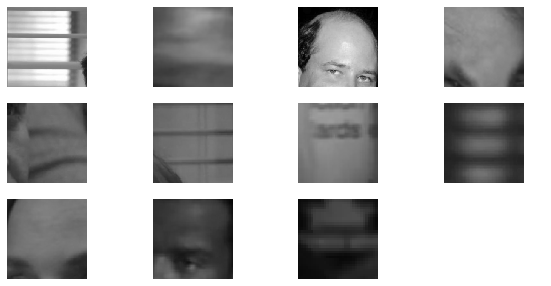

In [43]:
img_list = []
for pred_img_df in pred_img_df_list:
    example = pred_img_df
    for _,char_row in character_dict.items():
        for _, char_col in character_dict.items():
            if char_row != char_col:
                for img in example.loc[char_row][char_col]:
                        img_list.append(img)

_ = show_all_images(img_list)

And as per the performance outlined by the Google researchers, FaceNet worked very well for our dataset. The F1-Score that we got from using FaceNet hit 0.9711. When I first reached these results, my mind was blown. All the misclassified images for the first set of testing data are shown above. As you can see, the FaceNet classifier did not make a mistake when a face was found in the image. FaceNet only made a mistake when the LBPH facial detection mispredicted the location of a face in the picture.  So in turn, if we can reduce the number of false positive detected faces, we should see better performance on the classifier's end. 

## Implementing Multi-Task Convolutional Neural Network (MTCNN) Facial Detection

Seeing how well FaceNet performed on classifying faces from a set of faces, there must be a better way to actually detect faces than the LBPH classifier. Our original motivation for using LBPH detection was to trade off fine-tuning facial detection for classification. But now that we know the power of CNNs for facial classification, there has to be a ready-made CNN for facial detection. And indeed, there is.

The Multi-Task Convolutional Neural Network (MTCNN) is a CNN designed by Zhang et. al that can detect faces from an image with a resolution of up to 20x20 pixels (3). It does this via three independent CNN model process known as PRO: P(roposal), R(efinement), O(utput). Each step of the PRO process feeds into the next with the output being a bounding box where the face was found alongside landmark points where the individual's eyes, nose, and mouth corners are located in the image. Using thousands of images from the three datasets Face Detection Data Set and Benchmark, WIDER FACE, and Annotated Facial Landmarks in the Wild (AFLW), Zhang et. al. saw a 13% improvement of L2 distance between predicted facial landmarks and their ground truth labelled locations.

MTCNN is the best implementation we have so far of facial detection and we can work with it by using Iván de Paz Centeno's implementation of MTCNN on github (4). To work with MTCNN, you can run ```pip install mtcnn``` to load MTCNN into your project enviroment. From there, MTCNN can be used to detect faces using the MTCNN ```detect_faces``` function on the image data.

---

The two functions that we need to edit to interface MTCNN with our project are is our own ```detect_faces``` function and ```prepare_image_dictionaries```. We need to edit ```detect_faces``` since our original ```detect_faces``` function assumed that we were using the OpenCV LBPH classifier and we have to use the MTCNN now. In addition, we need to edit ```prepare_image_dictionaries``` so that we pass in MTCNN as our detection method when running ```detect_faces```. Thankfully, our ```cross_validate``` function is good as is.

In [44]:
from mtcnn.mtcnn import MTCNN

In [45]:
'''Detect faces from a photograph using MTCNN'''

def detect_faces(img, detector):
    
    rect_coord_list = []
    faces_list = []

    # Run facial detection on the image
    faces = detector.detect_faces(img)
    if len(faces)==0:
        return None, None
    
    # Create face and rectangle coordinate lists from facial detection
    for face in faces:
        (x, y, w, h) = face['box']
        if h == 0 or w == 0:
            return None, None
        faces_list.append(img[y:y+h, x:x+w])
        rect_coord_list.append((x, y, w, h))
    
    # Return face image and coordinates where the face was found
    return faces_list, rect_coord_list

In [46]:
''' Edit the prepare_image_dictionaries function to use MTCNN when detecting faces '''

def prepare_image_dictionaries(original_list, label_list, preprocess_steps):
    
    img_dict = defaultdict(list)
    face_dict = defaultdict(list)
    super_face_list = []
    detector = MTCNN()
    
    # Organize the original image and face lists by their corresponding labels
    for img, label in zip(original_list, label_list):
        faces, _ = detect_faces(img, detector)
        if faces is not None:
            img_dict[label].append(img)
            face_dict[label].append(faces[0])
    
    # Add all the faces from the face dictionary to a gray_face_list super list
    for _, face_list in face_dict.items():
        for face in face_list:
            super_face_list.append(face)
    
    # Process all the faces in the super list
    process_face_list = preprocess_images(super_face_list, preprocess_steps)
    
    # Store the processed faces to the face dictionary
    start = end = 0
    for label, img_list in img_dict.items():
        start, end = end, end + len(img_list)
        face_dict[label] = process_face_list[start:end]
  
    return img_dict, face_dict

In [47]:
character_dict, original_list, label_list = prepare_data('reference/7-Hyperparameter_Tuning/*/*.png', -2)
feature_extractor = load_model('facenet_keras.h5')
preprocess_steps = []
project_path = 'reference/7-Hyperparameter_Tuning'

/media/qiujing/e5439522-63c4-4b7c-a968-fefee6a3d960/omead/anaconda3/envs/face_project/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [48]:
pred_img_df_list, confusion_matrix_list, f1_average_list, cv_average_f1, t_list = cross_validate(original_list, 
                                                                                         label_list, 
                                                                                         feature_extractor, 
                                                                                         character_dict, 
                                                                                         project_path, 
                                                                                         preprocess_steps, 
                                                                                         num_samples=100, folds=5, 
                                                                                         random_state=42)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=804x1136 at 0x7FEC6C7284A8>: 100%|██████████| 100/100 [00:02<00:00, 40.15 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=118x136 at 0x7FEC6C7105C0>: 100%|██████████| 100/100 [00:01<00:00, 70.53 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=696x856 at 0x7FEC6F77B9B0>: 100%|██████████| 100/100 [00:04<00:00, 21.15 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=160x235 at 0x7FEC6C72DF60>: 100%|██████████| 100/100 [00:01<00:00, 53.64 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 23 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=281x379 at 0x7FEC6C7355F8>: 100%|██████████| 100/100 [00:02<00:00, 48.82 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=179x159 at 0x7FEC6C70D278>: 100%|██████████| 100/100 [00:01<00:00, 54.11 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=1388x1246 at 0x7FEC6F772A90>: 100%|██████████| 100/100 [00:03<00:00, 32.87 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=213x210 at 0x7FEC6F78A438>: 100%|██████████| 100/100 [00:00<00:00, 119.69 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=396x624 at 0x7FEC6C720DD8>: 100%|██████████| 100/100 [00:03<00:00, 28.54 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=349x411 at 0x7FEC6F7625C0>: 100%|██████████| 100/100 [00:01<00:00, 62.77 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=445x515 at 0x7FEC6C71E128>: 100%|██████████| 100/100 [00:03<00:00, 26.33 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 32 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=704x966 at 0x7FEC6C70BB38>: 100%|██████████| 100/100 [00:04<00:00, 23.57 Samples/s] 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 41 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=1352x1086 at 0x7FEC6F7639B0>: 100%|██████████| 100/100 [00:03<00:00, 25.21 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=406x507 at 0x7FEC6F783B00>: 100%|██████████| 100/100 [00:04<00:00, 24.99 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=232x298 at 0x7FEC6C707C88>: 100%|██████████| 100/100 [00:01<00:00, 85.64 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=269x367 at 0x7FEC6C731E10>: 100%|██████████| 100/100 [00:00<00:00, 244.62 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 27 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=414x487 at 0x7FEC6F775B38>: 100%|██████████| 100/100 [00:01<00:00, 61.56 Samples/s]               
Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=110x116 at 0x7FEC6F767C18>:   8%|▊         | 8/100 [00:00<00:14,  6.30 Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=157x192 at 0x7FEC6F767080>: 100%|██████████| 100/100 [00:00<00:00, 281.27 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=804x1136 at 0x7FEC6F74AA90>: 100%|██████████| 100/100 [00:02<00:00, 34.11 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=118x136 at 0x7FEC6FD4E518>: 100%|██████████| 100/100 [00:00<00:00, 130.32 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=812x1084 at 0x7FEC6F745C88>: 100%|██████████| 100/100 [00:04<00:00, 23.65 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=415x528 at 0x7FEC6CEE29E8>: 100%|██████████| 100/100 [00:01<00:00, 57.87 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 23 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=281x379 at 0x7FEC6F70F1D0>: 100%|██████████| 100/100 [00:02<00:00, 47.25 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=296x407 at 0x7FEC6FD4E860>: 100%|██████████| 100/100 [00:01<00:00, 51.84 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=291x296 at 0x7FEC6F737438>: 100%|██████████| 100/100 [00:01<00:00, 74.76 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=213x210 at 0x7FEC6F7384E0>: 100%|██████████| 100/100 [00:00<00:00, 111.27 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x762 at 0x7FEC6F743A90>: 100%|██████████| 100/100 [00:03<00:00, 25.98 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=349x411 at 0x7FEC6F712CF8>: 100%|██████████| 100/100 [00:01<00:00, 59.55 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=445x515 at 0x7FEC6CED7EF0>: 100%|██████████| 100/100 [00:03<00:00, 25.18 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 32 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=704x966 at 0x7FEC6F71C438>: 100%|██████████| 100/100 [00:03<00:00, 27.92 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 41 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=1352x1086 at 0x7FEC6FD4F160>: 100%|██████████| 100/100 [00:04<00:00, 21.51 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=406x507 at 0x7FEC6CEE91D0>: 100%|██████████| 100/100 [00:03<00:00, 27.98 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=289x435 at 0x7FEC6C714BA8>: 100%|██████████| 100/100 [00:01<00:00, 81.75 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=192x287 at 0x7FEC6FD4EC88>:   1%|          | 1/100 [00:00<00:19,  5.09 Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=351x448 at 0x7FEC6F743B70>: 100%|██████████| 100/100 [00:00<00:00, 247.13 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 27 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=414x487 at 0x7FEC6F7329E8>: 100%|██████████| 100/100 [00:00<00:00, 124.03 Samples/s]              
Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=110x116 at 0x7FEC6FD4D160>:   8%|▊         | 8/100 [00:00<00:11,  7.73 Samples/s]

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=157x192 at 0x7FEC6F720208>: 100%|██████████| 100/100 [00:00<00:00, 307.94 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=804x1136 at 0x7FEC6FD6AA90>: 100%|██████████| 100/100 [00:02<00:00, 36.25 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=118x136 at 0x7FEC6EF7A710>: 100%|██████████| 100/100 [00:01<00:00, 84.72 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=812x1084 at 0x7FEC6C6E76A0>: 100%|██████████| 100/100 [00:03<00:00, 26.61 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=415x528 at 0x7FEC6E710A90>: 100%|██████████| 100/100 [00:02<00:00, 44.78 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 23 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=269x430 at 0x7FEC6FD75710>: 100%|██████████| 100/100 [00:02<00:00, 45.08 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=296x407 at 0x7FEC6EF750F0>: 100%|██████████| 100/100 [00:01<00:00, 67.84 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=291x296 at 0x7FEC6E7250B8>: 100%|██████████| 100/100 [00:02<00:00, 34.93 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=370x512 at 0x7FEC6FD87A58>: 100%|██████████| 100/100 [00:00<00:00, 144.01 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x762 at 0x7FEC6EF85C50>: 100%|██████████| 100/100 [00:04<00:00, 24.45 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=178x223 at 0x7FEC6E716AC8>: 100%|██████████| 100/100 [00:01<00:00, 55.86 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=445x515 at 0x7FEC6FD8B128>: 100%|██████████| 100/100 [00:03<00:00, 30.46 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 32 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=704x966 at 0x7FEC6FD747B8>: 100%|██████████| 100/100 [00:03<00:00, 28.49 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 41 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=1352x1086 at 0x7FEC6FD197F0>: 100%|██████████| 100/100 [00:04<00:00, 24.24 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=406x507 at 0x7FEC6FD13F98>: 100%|██████████| 100/100 [00:03<00:00, 32.72 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=289x435 at 0x7FEC6FD6D5C0>: 100%|██████████| 100/100 [00:00<00:00, 109.86 Samples/s]              
Processing <PIL.Image.Image image mode=RGB size=155x204 at 0x7FEC6C6EAA20>:   1%|          | 1/100 [00:00<00:19,  5.15 Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=351x448 at 0x7FEC6FD20A58>: 100%|██████████| 100/100 [00:00<00:00, 243.26 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 27 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=414x487 at 0x7FEC6EF7EBE0>: 100%|██████████| 100/100 [00:01<00:00, 70.55 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=196x263 at 0x7FEC6C6E7B38>:   2%|▏         | 2/100 [00:00<00:17,  5.61 Samples/s]                

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=211x255 at 0x7FEC6C6EA048>: 100%|██████████| 100/100 [00:00<00:00, 246.86 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=804x1136 at 0x7FEC6E75FB00>: 100%|██████████| 100/100 [00:02<00:00, 34.13 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=158x192 at 0x7FEC6E76E438>: 100%|██████████| 100/100 [00:01<00:00, 79.20 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=812x1084 at 0x7FEC6F03EBA8>: 100%|██████████| 100/100 [00:04<00:00, 21.97 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=415x528 at 0x7FEC6E762128>: 100%|██████████| 100/100 [00:02<00:00, 47.52 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 23 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=269x430 at 0x7FEC6E7606A0>: 100%|██████████| 100/100 [00:01<00:00, 50.05 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=296x407 at 0x7FEC6E8EBC18>: 100%|██████████| 100/100 [00:01<00:00, 59.88 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=291x296 at 0x7FEC6E756D30>: 100%|██████████| 100/100 [00:02<00:00, 37.71 Samples/s] 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=370x512 at 0x7FEC6EE732B0>: 100%|██████████| 100/100 [00:01<00:00, 91.84 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x762 at 0x7FEC6EF87588>: 100%|██████████| 100/100 [00:04<00:00, 24.98 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=178x223 at 0x7FEC6E771B70>: 100%|██████████| 100/100 [00:01<00:00, 61.56 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=768x884 at 0x7FEC6F020C50>: 100%|██████████| 100/100 [00:04<00:00, 22.09 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 32 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=704x966 at 0x7FEC6E76EDD8>: 100%|██████████| 100/100 [00:03<00:00, 27.12 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 41 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.Image.Image image mode=RGB size=1352x1086 at 0x7FEC6E77DBE0>: 100%|██████████| 100/100 [00:04<00:00, 24.76 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=406x507 at 0x7FEC6E755438>: 100%|██████████| 100/100 [00:03<00:00, 32.71 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=289x435 at 0x7FEC6F043B38>: 100%|██████████| 100/100 [00:01<00:00, 81.32 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=180x220 at 0x7FEC6EFEBC18>:   1%|          | 1/100 [00:00<00:19,  5.18 Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=351x448 at 0x7FEC6EF87C50>: 100%|██████████| 100/100 [00:00<00:00, 226.23 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 27 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=279x344 at 0x7FEC6E75FB70>: 100%|██████████| 100/100 [00:01<00:00, 66.46 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=179x208 at 0x7FEC6F03EE80>:   4%|▍         | 4/100 [00:00<00:16,  5.98 Samples/s]                

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=211x255 at 0x7FEC6F0868D0>: 100%|██████████| 100/100 [00:00<00:00, 268.65 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=254x383 at 0x7FEC6E883828>: 100%|██████████| 100/100 [00:02<00:00, 45.81 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=158x192 at 0x7FEC6DF88FD0>: 100%|██████████| 100/100 [00:01<00:00, 82.46 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=812x1084 at 0x7FEC6E7E70B8>: 100%|██████████| 100/100 [00:04<00:00, 20.89 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=415x528 at 0x7FEC6CF2DE80>: 100%|██████████| 100/100 [00:01<00:00, 65.09 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 23 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=269x430 at 0x7FEC6DF87160>: 100%|██████████| 100/100 [00:01<00:00, 67.57 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=296x407 at 0x7FEC6CF2EA58>: 100%|██████████| 100/100 [00:01<00:00, 73.12 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=291x296 at 0x7FEC6DF731D0>: 100%|██████████| 100/100 [00:02<00:00, 42.75 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=370x512 at 0x7FEC6CF2A208>: 100%|██████████| 100/100 [00:01<00:00, 92.87 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=608x762 at 0x7FEC6DF7DA90>: 100%|██████████| 100/100 [00:03<00:00, 26.36 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 22 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=178x223 at 0x7FEC6DF796D8>: 100%|██████████| 100/100 [00:01<00:00, 66.21 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=768x884 at 0x7FEC6E7F8748>: 100%|██████████| 100/100 [00:04<00:00, 24.97 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 32 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=277x322 at 0x7FEC6CF0BA58>: 100%|██████████| 100/100 [00:03<00:00, 27.59 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 41 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=277x363 at 0x7FEC6E867DD8>: 100%|██████████| 100/100 [00:03<00:00, 29.05 Samples/s] 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 34 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=1292x1120 at 0x7FEC6E7F8F28>: 100%|██████████| 100/100 [00:03<00:00, 28.68 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=289x435 at 0x7FEC6EF14518>: 100%|██████████| 100/100 [00:00<00:00, 102.66 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 20 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=351x448 at 0x7FEC6EF17400>: 100%|██████████| 100/100 [00:00<00:00, 214.41 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 27 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=279x344 at 0x7FEC6CF37048>: 100%|██████████| 100/100 [00:01<00:00, 68.95 Samples/s]                
Processing <PIL.Image.Image image mode=RGB size=110x116 at 0x7FEC6E89FD30>:   9%|▉         | 9/100 [00:00<00:14,  6.34 Samples/s]                

Initialised with 14 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=211x255 at 0x7FEC6E808860>: 100%|██████████| 100/100 [00:00<00:00, 312.74 Samples/s]              


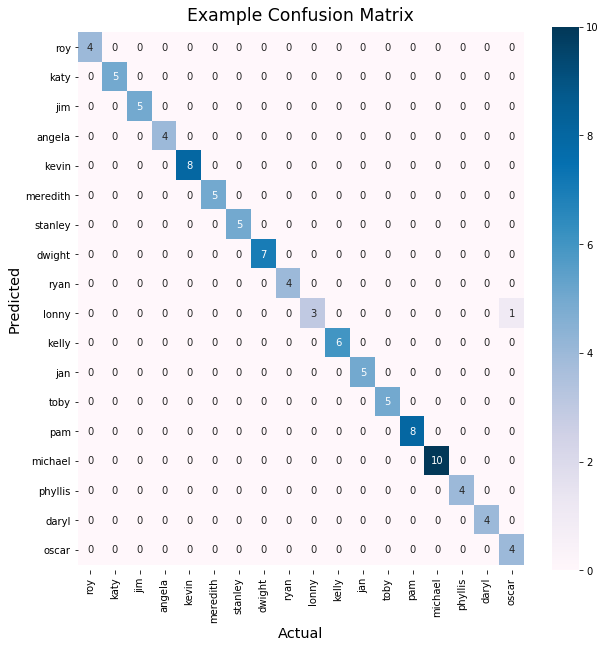

In [49]:
example = confusion_matrix_list[0]

_ = plt.figure(figsize=(10,10))
_ = plt.tight_layout()
_ = sns.heatmap(example, annot=True, cmap='PuBu')
_ = plt.title('Example Confusion Matrix', fontsize='xx-large')
_ = plt.xlabel('Actual', fontsize='x-large')
_ = plt.ylabel('Predicted', fontsize='x-large')
_ = plt.ylim(example.shape[1] + 0.2, -0.2)

In [50]:
print("Average F1 Score from 5-Fold CV: {:.4f}".format(cv_average_f1))

Average F1 Score from 5-Fold CV: 0.9972


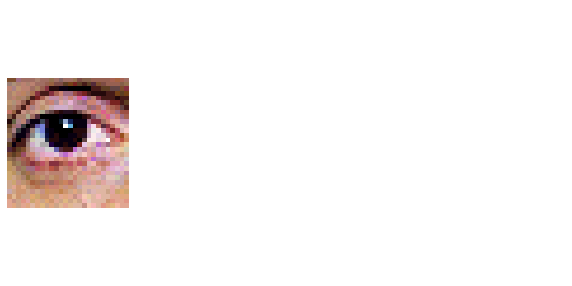

In [51]:
img_list = []
for pred_img_df in pred_img_df_list:
    example = pred_img_df
    for _,char_row in character_dict.items():
        for _, char_col in character_dict.items():
            
            # Add all the images in the image DataFrame that were misclassified
            if char_row != char_col:
                for img in example.loc[char_row][char_col]:
                        img_list.append(img)

_ = show_all_images(img_list)

And there you have it. This is the best possible performance we can get for facial recognition. Using MTCNN for facial detection and FaceNet for facial recognition, we only made a single mistake across 5-Fold CV. That's phenomenal. Another note is that MTCNN was better at removing False Positives and adding True Positives when detecting faces from a frame. In short, MTCNN was able to better find faces from the provided pictures which all had faces to detect.

Below is a summary of all the steps needed to predict new faces using MTCNN and FaceNet.

---

# Steps for Making New Predictions

### Step 1: Organize training images into a default_dict

In [52]:
# Retrieve all the images from the project reference folder
character_dict, original_list, label_list = prepare_data('reference/7-Hyperparameter_Tuning/*/*.png', -2)

# Prepare original image dictionary using the prepare_image_dictionary function
img_dict, _ = prepare_image_dictionaries(original_list, label_list, preprocess_steps)

### Step 2: Augment the training images

In [53]:
'''Augment the images from the training path that you want to train with'''

def augment_training_images(character_dict, project_path, img_dict,
                             num_samples=100, random_state=None):
        
    # Gather all the original images for a character each individual character
    for (label, img_list) in img_dict.items():

        # Train on all the original images
        train_split = img_list

        # Save training images to training directory
        character = character_dict[label]
        training_path = make_training_directory(character, project_path)
        for img_num, face in enumerate(train_split):
            img_path = '{}/{}.png'.format(training_path, img_num)
            _ = cv2.imwrite(img_path, face)

        # Augment the face images from the training directory and save augmentation to output directory
        _ = augment_images(training_path, num_samples, random_state)

In [54]:
project_path = 'reference/7-Hyperparameter_Tuning'
_ = augment_training_images(character_dict, project_path, img_dict, num_samples=100, random_state=42)

Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 24 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.Image.Image image mode=RGB size=296x407 at 0x7FEC6CC5DB00>: 100%|██████████| 100/100 [00:01<00:00, 61.35 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=259x310 at 0x7FEC6CC4AF60>:   2%|▏         | 2/100 [00:00<00:19,  5.07 Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=259x310 at 0x7FEC6CC14320>: 100%|██████████| 100/100 [00:00<00:00, 237.43 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=848x898 at 0x7FEC6CC0D978>: 100%|██████████| 100/100 [00:03<00:00, 27.13 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 24 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=472x614 at 0x7FEC6CC63D30>: 100%|██████████| 100/100 [00:01<00:00, 50.71 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 42 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=338x469 at 0x7FEC6CC08978>: 100%|██████████| 100/100 [00:02<00:00, 45.39 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=144x167 at 0x7FEC6CC5FBE0>: 100%|██████████| 100/100 [00:01<00:00, 79.76 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 27 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=246x288 at 0x7FEC6CC6BD30>: 100%|██████████| 100/100 [00:00<00:00, 116.86 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 39 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=312x319 at 0x7FEC6CC457F0>: 100%|██████████| 100/100 [00:03<00:00, 27.11 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 23 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=1086x1268 at 0x7FEC6CC71B38>: 100%|██████████| 100/100 [00:04<00:00, 20.13 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=252x302 at 0x7FEC6CC4E630>:   8%|▊         | 8/100 [00:00<00:14,  6.57 Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=284x235 at 0x7FEC6CC71198>: 100%|██████████| 100/100 [00:00<00:00, 312.61 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 33 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=163x176 at 0x7FEC6CC7A710>: 100%|██████████| 100/100 [00:01<00:00, 75.47 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=329x430 at 0x7FEC6CC398D0>: 100%|██████████| 100/100 [00:03<00:00, 27.33 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 28 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=552x736 at 0x7FEC6CC23F60>: 100%|██████████| 100/100 [00:02<00:00, 48.80 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 42 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=636x914 at 0x7FEC6CC21D30>: 100%|██████████| 100/100 [00:03<00:00, 26.99 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 51 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=326x404 at 0x7FEC6CC72F28>: 100%|██████████| 100/100 [00:03<00:00, 29.85 Samples/s] 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 23 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=307x295 at 0x7FEC6CCC46D8>: 100%|██████████| 100/100 [00:02<00:00, 42.52 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 24 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=352x413 at 0x7FEC6CC44710>: 100%|██████████| 100/100 [00:01<00:00, 78.21 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 27 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=223x285 at 0x7FEC6CC359E8>: 100%|██████████| 100/100 [00:01<00:00, 63.24 Samples/s]               


### Step 3: Embed the training images using the FaceNet classifier

In [55]:
'''Extract features from images using FaceNet'''
def embed_training_images(project_path, feature_extractor):
     
        # Retrieve augmented image data for img embedding
        training_img_path = project_path + '/*/training/output/*.png' 
        _, train_img_list, train_label_list = prepare_data(training_img_path, -4)
        
        # Gather faces from augmented training data
        _, augment_face_dict = prepare_image_dictionaries(train_img_list, 
                                                       train_label_list, 
                                                       [])
        
        # Convert the training faces to 128-element embedded FaceNet vectors
        embed_augment_face_dict = defaultdict(list)
        for key, face_list in augment_face_dict.items():
            embedding_face_list = []
            for face in face_list:
                if face is None or face.shape[0] == 0 or face.shape[1] == 0:
                    continue
                embedding = embed_face(face, feature_extractor)
                embedding_face_list.append(embedding)
            embed_augment_face_dict[key] = embedding_face_list
        
        return embed_augment_face_dict

In [56]:
feature_extractor = load_model('facenet_keras.h5')
embed_augment_face_dict = embed_training_images(project_path, feature_extractor)

/media/qiujing/e5439522-63c4-4b7c-a968-fefee6a3d960/omead/anaconda3/envs/face_project/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [57]:
example = embed_augment_face_dict[0]
print(example[0].shape)

(128,)


### Step 4: Apply MTCNN facial detection to test images

In [58]:
''' 
testing_img_class used to categorize images with their corresponding faces, face coordinates, and embedded vectors
'''

class testing_img_class(object):
    
    def __init__(self, img, face_list, rect_coord_list):
        self.img = img
        self.face_list = face_list
        self.rect_coord_list = rect_coord_list
        self.embedded_face_list = self.prediction_list = []
    
    def add_embedding_list(self, embedding_list):
        self.embedded_face_list = embedding_list
    
    def add_predictions(self, prediction_list):
        self.prediction_list = prediction_list
    
    

In [59]:
''' Generates list of test_img_class class types that store img and faces / coordinates of where face was found '''

def detect_faces_from_testing_imgs(test_img_list):
    
    test_img_class_list = []
    detector = MTCNN()
    
    # Organize the original image and face lists by their corresponding labels
    for img in test_img_list:
        face_list, rect_coord_list = detect_faces(img, detector)
        if face_list is not None and rect_coord_list is not None:
            temp = testing_img_class(img, face_list, rect_coord_list)
            test_img_class_list.append(temp)
  
    return test_img_class_list

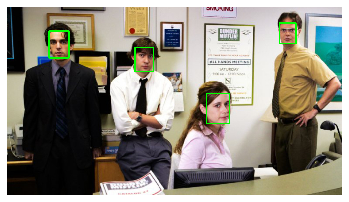

In [60]:
# Gather all the testing images from the project folder
img_path_list = glob('reference/7-Hyperparameter_Tuning/test/*')
img_list = []
for path in img_path_list:
    img = create_img(path)
    img_list.append(img)

# Create test_img_class objects from gathered images
test_img_class_list = detect_faces_from_testing_imgs(img_list)

# Draw a green rectangle around the faces in the image
example_list = []
green = (0, 255, 0)
for item in test_img_class_list:
    img_copy = item.img.copy()
    for rect in item.rect_coord_list:
        (x, y, w, h) = rect
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), green, 2)
    example_list.append(img_copy)
    
# Display example images with detected faces
example = example_list[0]
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
_ = plt.imshow(example)
_ = plt.axis('off')

### Step 5: Embed the test images using the FaceNet classifier

In [61]:
''' Adds all the embedded vectors to the test img class list'''
def embed_testing_images(test_img_class_list, feature_extractor):
        
    # Convert the testing faces to 128-element embedded FaceNet vectors
    for item in test_img_class_list:
        embedding_face_list = []
        for face in item.face_list:
            embedding = embed_face(face, feature_extractor)
            embedding_face_list.append(embedding)
        item.add_embedding_list(embedding_face_list)

In [62]:
embed_testing_images(test_img_class_list, feature_extractor)

example = test_img_class_list[0]
print(example.embedded_face_list[0].shape)

(128,)


### Step 5: Train SVM using training vector list and label list

In [63]:
'''Train SVM on embeddings from augmented image data'''
def train_SVM(embed_augment_face_dict):
    
    # Generate the final training embedding list and labels from embed_augment_face_dict
    train_X = []
    train_y = np.array([])
    for (label, embed_list) in embed_augment_face_dict.items():
        for embed in embed_list:
            train_X.append(embed)
        train_y = np.append(train_y, np.full(len(embed_list), label))
    train_X = np.asarray(train_X)
    
    # Train a linear SVM for facial recognition
    model = SVC(kernel='linear')
    model.fit(train_X, train_y)
    
    return model

In [64]:
model = train_SVM(embed_augment_face_dict)

### Step 6: Use SVM on test images

In [65]:
'''Run predictions using trained SVM on testing embedding set'''

def test_SVM(test_img_class_list, character_dict, model):
    for item in test_img_class_list:
        # Predict on the testing image set
        test_X = item.embedded_face_list
        pred_y = model.predict(test_X)
        item.add_predictions(pred_y)

In [66]:
_ = test_SVM(test_img_class_list, character_dict, model)

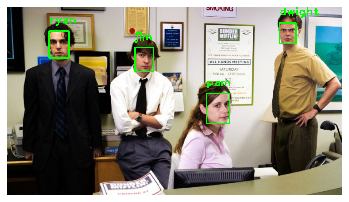

In [67]:
# Draw a green rectangle around the faces in the image
example_list = []
green = (0, 255, 0)
for item in test_img_class_list:
    img_copy = item.img.copy()
    for label, rect in zip(item.prediction_list, item.rect_coord_list):
        character = character_dict[label]
        (x, y, w, h) = rect
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), green, 2)
        cv2.putText(img_copy, character, (x, y-15), cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, color=green, thickness=2)
    example_list.append(img_copy)
    
# Display example images with detected faces and character name
example = example_list[0]
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
_ = plt.imshow(example)
_ = plt.axis('off')

### Step 7: Save faces to the predicted character's prediction directory

In [68]:
''' Create clean prediction directories for all the characters '''

def make_prediction_directories(character_dict, path):
    for _, character in character_dict.items():
        
        prediction_path = path + '/' + character + '/prediction'
        # Create a fresh prediction directory for each character
        try:
            _ = os.mkdir(prediction_path)
        except FileExistsError:
            _ = shutil.rmtree(prediction_path)
            _ = os.mkdir(prediction_path)

In [69]:
''' Save all the predicted faces to the predicted character's project directory'''

def save_faces(test_img_class_list, path, character_dict):
    for item in test_img_class_list:
        for (face, label) in zip(item.face_list, item.prediction_list):
            
            # Find the name of the character associated with the label
            character = character_dict[label]
            
            # Save the face to the first available image number name
            i = 1
            prediction_path = path + '/' + character + '/prediction'
            while os.path.exists("{}/{}.png".format(prediction_path, i)):
                i += 1
            img_path = '{}/{}.png'.format(prediction_path, i)
            _ = cv2.imwrite(img_path, face)

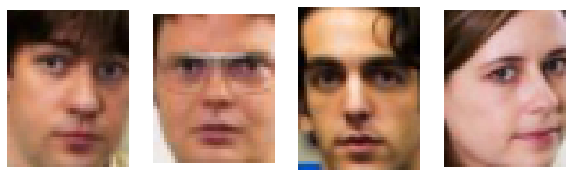

In [70]:
project_path = 'reference/7-Hyperparameter_Tuning'

_ = make_prediction_directories(character_dict, project_path)
_ = save_faces(test_img_class_list, project_path, character_dict)

# Gather all the predicted faces from every prediction directory in the project path
glob_pattern = project_path + '/*/prediction/*'
img_path_list = glob(glob_pattern)
predicted_face_list = []
for path in img_path_list:
    img = create_img(path)
    predicted_face_list.append(img)

# Display the images
_ = show_all_images(predicted_face_list)

---

# Putting Everything Together

In [71]:
# Step 1: Organize training images into a default_dict
character_dict, original_list, label_list = prepare_data('reference/7-Hyperparameter_Tuning/*/*.png', -2)
img_dict, _ = prepare_image_dictionaries(original_list, label_list, preprocess_steps)

# Step 2: Augment the training images
project_path = 'reference/7-Hyperparameter_Tuning'
_ = augment_training_images(character_dict, project_path, img_dict, num_samples=100, random_state=42)

# Step 3: Embed the training images using the FaceNet classifier
feature_extractor = load_model('facenet_keras.h5')
embed_augment_face_dict = embed_training_images(project_path, feature_extractor)

# Step 4: Apply MTCNN facial detection to test images
_ = embed_testing_images(test_img_class_list, feature_extractor)

# Step 5: Train SVM using training vector list and label list
model = train_SVM(embed_augment_face_dict)

# Step 6: Use SVM on test images
_ = test_SVM(test_img_class_list, character_dict, model)

# Step 7: Save faces to the predicted character's prediction directory
_ = make_prediction_directories(character_dict, project_path)
_ = save_faces(test_img_class_list, project_path, character_dict)

Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 24 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/roy/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=296x407 at 0x7FEC2BF70550>: 100%|██████████| 100/100 [00:01<00:00, 59.78 Samples/s]
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/katy/training/output.

Processing <PIL.Image.Image image mode=RGB size=259x310 at 0x7FEC2CF8F198>: 100%|██████████| 100/100 [00:00<00:00, 229.10 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 25 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jim/training/output.

Processing <PIL.Image.Image image mode=RGB size=848x898 at 0x7FEC2CF8CCF8>: 100%|██████████| 100/100 [00:03<00:00, 27.33 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 24 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/angela/training/output.

Processing <PIL.Image.Image image mode=RGB size=472x614 at 0x7FEC2BF6FE80>: 100%|██████████| 100/100 [00:01<00:00, 54.95 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 42 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kevin/training/output.

Processing <PIL.Image.Image image mode=RGB size=338x469 at 0x7FEC2BF50EF0>: 100%|██████████| 100/100 [00:02<00:00, 48.04 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/meredith/training/output.

Processing <PIL.Image.Image image mode=RGB size=144x167 at 0x7FEC2BF47748>: 100%|██████████| 100/100 [00:01<00:00, 87.89 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 27 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/stanley/training/output.

Processing <PIL.Image.Image image mode=RGB size=246x288 at 0x7FEC2BF7D780>: 100%|██████████| 100/100 [00:00<00:00, 104.84 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 39 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/dwight/training/output.

Processing <PIL.Image.Image image mode=RGB size=312x319 at 0x7FEC2BF78860>: 100%|██████████| 100/100 [00:04<00:00, 24.57 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 23 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/ryan/training/output.

Processing <PIL.Image.Image image mode=RGB size=1086x1268 at 0x7FEC6D46DCF8>: 100%|██████████| 100/100 [00:05<00:00, 19.50 Samples/s]               
Processing <PIL.Image.Image image mode=RGB size=211x255 at 0x7FEC6CC46518>:   2%|▏         | 2/100 [00:00<00:16,  5.79 Samples/s]

Initialised with 17 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/lonny/training/output.

Processing <PIL.Image.Image image mode=RGB size=284x235 at 0x7FEC6CC46470>: 100%|██████████| 100/100 [00:00<00:00, 284.65 Samples/s]              
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 33 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/kelly/training/output.

Processing <PIL.Image.Image image mode=RGB size=163x176 at 0x7FEC6CC2C160>: 100%|██████████| 100/100 [00:01<00:00, 91.66 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 26 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/jan/training/output.

Processing <PIL.Image.Image image mode=RGB size=329x430 at 0x7FEC2CFA8470>: 100%|██████████| 100/100 [00:03<00:00, 29.11 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 28 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/toby/training/output.

Processing <PIL.Image.Image image mode=RGB size=552x736 at 0x7FEC2CFA8D68>: 100%|██████████| 100/100 [00:01<00:00, 51.60 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 42 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/pam/training/output.

Processing <PIL.Image.Image image mode=RGB size=636x914 at 0x7FEC2CFA0470>: 100%|██████████| 100/100 [00:03<00:00, 25.94 Samples/s]                 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 51 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/michael/training/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=326x404 at 0x7FEC2EEFAC18>: 100%|██████████| 100/100 [00:03<00:00, 30.85 Samples/s] 
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 23 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/phyllis/training/output.

Processing <PIL.Image.Image image mode=RGB size=307x295 at 0x7FEC2CFB3B38>: 100%|██████████| 100/100 [00:02<00:00, 47.75 Samples/s]                
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 24 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/daryl/training/output.

Processing <PIL.Image.Image image mode=RGB size=352x413 at 0x7FEC2BF743C8>: 100%|██████████| 100/100 [00:01<00:00, 80.17 Samples/s]               
Executing Pipeline:   0%|          | 0/100 [00:00<?, ? Samples/s]

Initialised with 27 image(s) found.
Output directory set to reference/7-Hyperparameter_Tuning/oscar/training/output.

Processing <PIL.Image.Image image mode=RGB size=223x285 at 0x7FEC2BF6D8D0>: 100%|██████████| 100/100 [00:01<00:00, 62.65 Samples/s]                
/media/qiujing/e5439522-63c4-4b7c-a968-fefee6a3d960/omead/anaconda3/envs/face_project/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


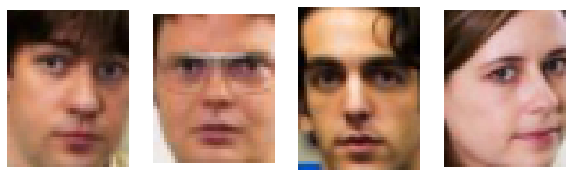

In [73]:
# project_path = 'reference/7-Hyperparameter_Tuning'

_ = make_prediction_directories(character_dict, project_path)
_ = save_faces(test_img_class_list, project_path, character_dict)

# Gather all the predicted faces from every prediction directory in the project path
glob_pattern = project_path + '/*/prediction/*'
img_path_list = glob(glob_pattern)
predicted_face_list = []
for path in img_path_list:
    img = create_img(path)
    predicted_face_list.append(img)

# Display the images
_ = show_all_images(predicted_face_list)

And there you have it. Our project can now be used to take frame data from video episodes of <i>The Office</i> and store the face frames to their character's respective folders. In the next installation of our blog series, we will import the video data from <i>The Office</i> using OpenCV. We'll then gather a handful of frames from the video data and run our classifier on it to see if the MTCNN/FaceNet classifiers are able to distinguish faces from the actual testing dataset. From there, we'll run the classifier model on all the frames from the show and find how much time each character spent on screen. Really exciting stuff! 

Before I end things off, I'd like to give a special thank you to Dr. Jason Brownlee for his textbook <b><i>Deep Learning for Computer Vision</i></b> (5). My discovery of FaceNet and MTCNN are all thanks to this textbook which contains amazing examples to get you started on machine learning and machine vision. If you're at all interested in computer vision, I'd definitely consider giving his textbook a read! That's all. Until next time, thanks for reading :)

---

# Works Cited

(1) Schroff, Florian, et al. “FaceNet: A Unified Embedding for Face Recognition and
    Clustering.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2015,
    doi:10.1109/cvpr.2015.7298682.

(2) https://github.com/nyoki-mtl/keras-facenet

(3) Zhang, Kaipeng, et al. “Joint Face Detection and Alignment Using Multitask Cascaded
    Convolutional Networks.” IEEE Signal Processing Letters, vol. 23, no. 10, 2016, pp. 1499–
    1503., doi:10.1109/lsp.2016.2603342.

(4) https://github.com/ipazc/mtcnn

(5) Brownlee, Jason. Deep Learning for Computer Vision: Image Classification, Object
    Detection, and Face Recognition in Python. 1.5 version, 2019,
    www.machinelearningmastery.com, 
    www.machinelearningmastery.com/deep-learning-for-computer-vision/.